# Forecast Airlines Passengers data set. Prepare a document for each model explaining  how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [12]:
# # Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import datetime
from scipy.stats import boxcox
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Load the data set 'Airlines+Data.xlsx'
df = pd.read_excel('Airlines+Data.xlsx')
df.head()

Month  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [15]:
# The month in the data frame is in the date time format, we will rename it to Date and set as index of the dataframe

In [16]:
df.rename({'Month':'Date'},axis = 1, inplace = True)

In [17]:
df.head()

Date  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


# Feature engineering

In [21]:
# Separate month and year from the date and create new columns

In [22]:
df["Date"]  = pd.to_datetime(df.Date, format="%b-%y")
df["month"] = df.Date.dt.strftime("%b")
df["year"]  = df.Date.dt.strftime("%Y")

In [23]:
df.head()

Date  Passengers month  year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995

In [24]:
# Create a dummy variable for month
dummy = pd.get_dummies(df['month'])

In [25]:
df = pd.concat((df,dummy),axis = 1)

In [26]:
df.head()

Date  Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
0 1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1 1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
2 1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
3 1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
4 1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

   May  Nov  Oct  Sep  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    1    0    0    0

In [27]:
# Set date as index of the data frame
df.set_index('Date',inplace = True)

In [28]:
df.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep  
Date                            
1995-01-01    0    0    0    0  
1995-02-01    0    0    0    0  
1995-03-01    0    0    0    0  
1995-04-01    0    0    0    0  
1995-05-01    1    0    0    0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1995-01-01 to 2002-12-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Passengers  96 non-null     int64 
 1   month       96 non-null     object
 2   year        96 non-null     object
 3   Apr         96 non-null     uint8 
 4   Aug         96 non-null     uint8 
 5   Dec         96 non-null     uint8 
 6   Feb         96 non-null     uint8 
 7   Jan         96 non-null     uint8 
 8   Jul         96 non-null     uint8 
 9   Jun         96 non-null     uint8 
 10  Mar         96 non-null     uint8 
 11  May         96 non-null     uint8 
 12  Nov         96 non-null     uint8 
 13  Oct         96 non-null     uint8 
 14  Sep         96 non-null     uint8 
dtypes: int64(1), object(2), uint8(12)
memory usage: 4.1+ KB


# Visualization of the data

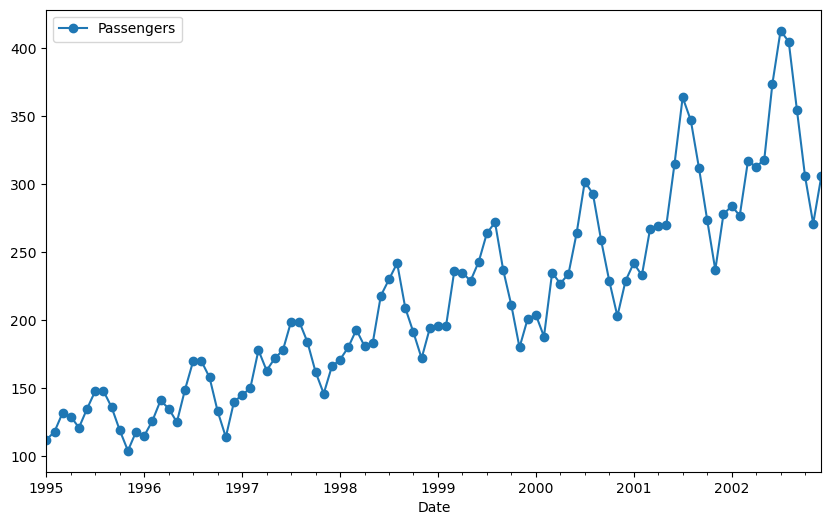

In [31]:
# Line plot visualization
plt.rcParams['figure.figsize'] = (10,6)
df['Passengers'].plot(legend = True , label = 'Passengers' , marker = 'o');

# From the above line plot, we can say that there is a TREND , Which is upward

# We can observe some seasonality also , We will plot heatmap and boxplot for more clarity

# Heat map visulalization

In [32]:
df_pivot = df.pivot_table(values = 'Passengers',index = df.index.year , columns = df.index.month)
df_pivot

Date   1    2    3    4    5    6    7    8    9    10   11   12
Date                                                            
1995  112  118  132  129  121  135  148  148  136  119  104  118
1996  115  126  141  135  125  149  170  170  158  133  114  140
1997  145  150  178  163  172  178  199  199  184  162  146  166
1998  171  180  193  181  183  218  230  242  209  191  172  194
1999  196  196  236  235  229  243  264  272  237  211  180  201
2000  204  188  235  227  234  264  302  293  259  229  203  229
2001  242  233  267  269  270  315  364  347  312  274  237  278
2002  284  277  317  313  318  374  413  405  355  306  271  306

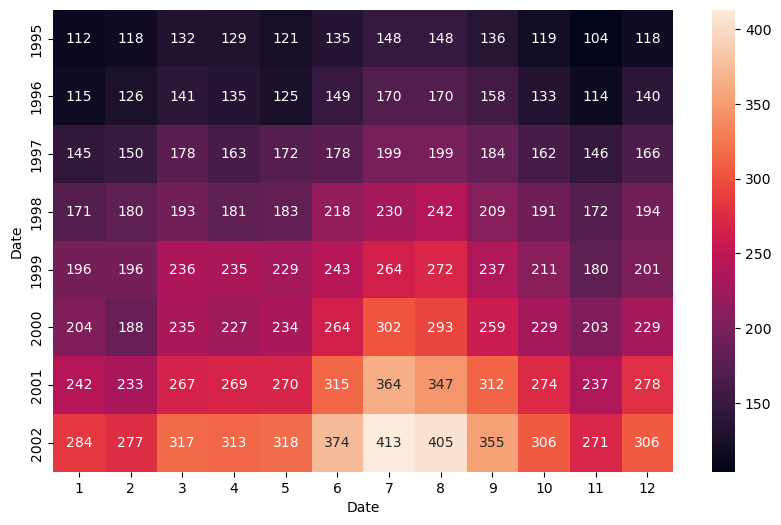

In [33]:
sns.heatmap(data = df_pivot , annot = True,fmt = 'g' );

# From the above heat map visualization , We can see that there are less number os passengers in the month of january and gradually increasing upto august and there is a decrease from september to december.We can observe seasonlity in the data

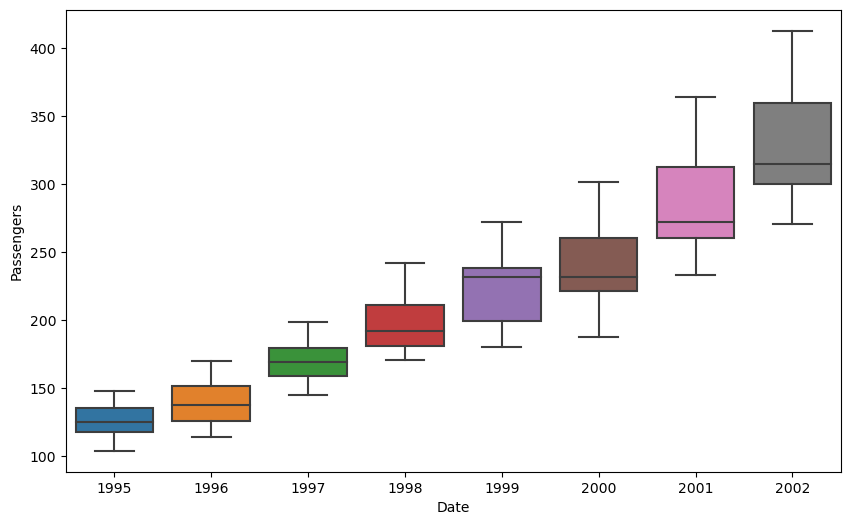

In [34]:
# BOX PLOT VISUALIZATION OF THE DATA
sns.boxplot(data = df , x = df.index.year, y = 'Passengers');

# There is a increase trend in the data

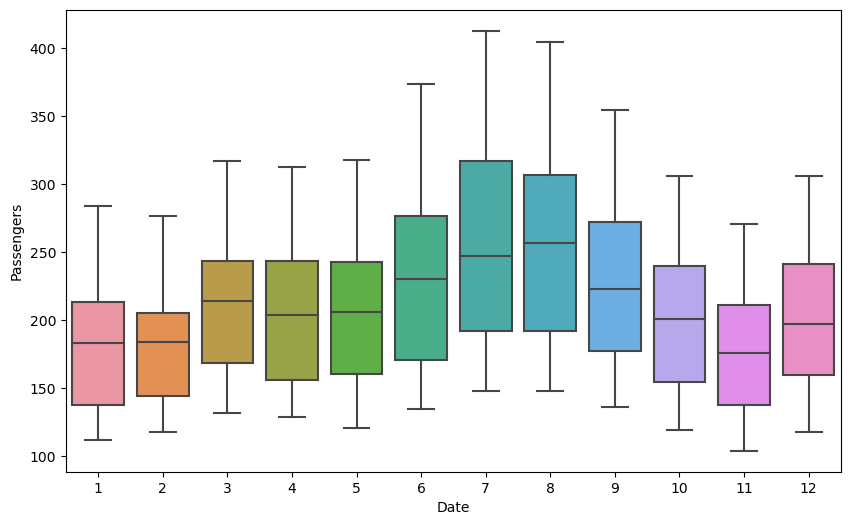

In [35]:
# Box plot visualization for the month 
sns.boxplot(data = df, x = df.index.month, y = 'Passengers');

# From the above boxplot , There are less number of passengers in the initial months of the year and there in a increase in the number of passengers from the month of june to september and then decrese in the number os passengers from oct to november

# Histogram and density plot

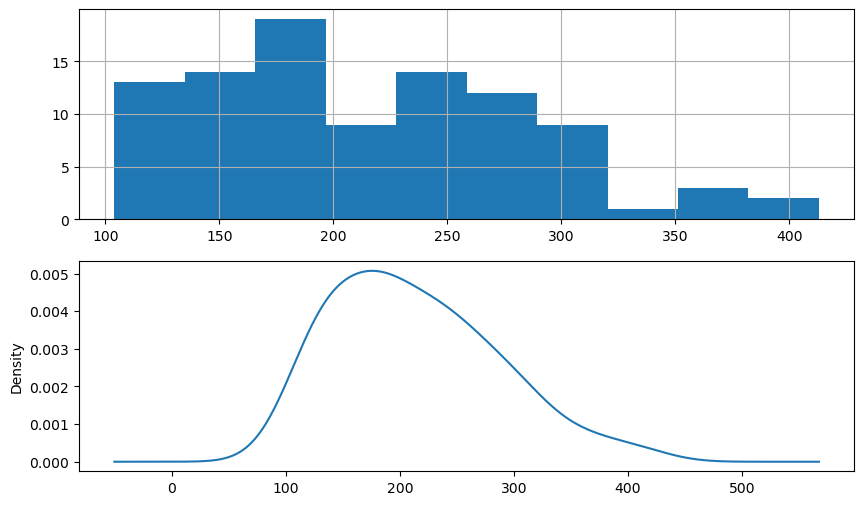

In [37]:
plt.subplot(211)
df.Passengers.hist()
plt.subplot(212)
df.Passengers.plot(kind='kde')
plt.show()

# The data in normally distributed

# Lag plot - Correlation between a time series and a lagged version of itself

In [38]:
# Import lag plot
from pandas.plotting import lag_plot

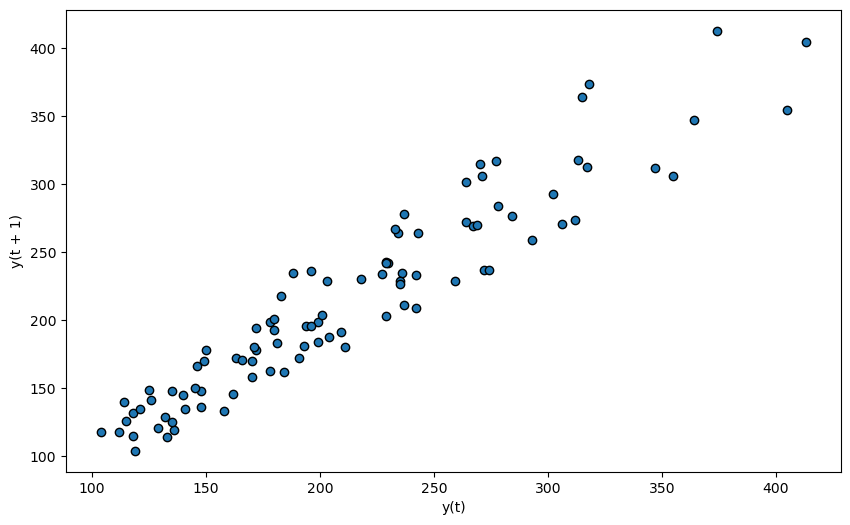

In [40]:
lag_plot(df['Passengers'],edgecolor = 'k'); # Default lag = 1

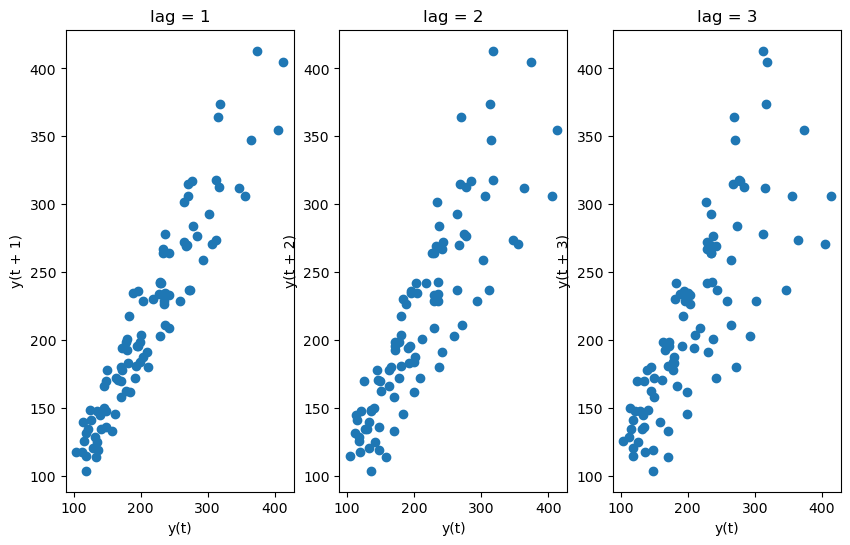

In [41]:
# Lag plot with a lag of 1,2 and 3
fig,ax = plt.subplots(1,3)

for i,lag in enumerate([1,2,3]):
    lag_plot(df['Passengers'],lag = lag,ax = ax[i])
    ax[i].set_title(f'lag = {lag}')

# With a lag of 1 , The distribution is not scattered more from lag 2 the distribution is scattering more

# Moving average model

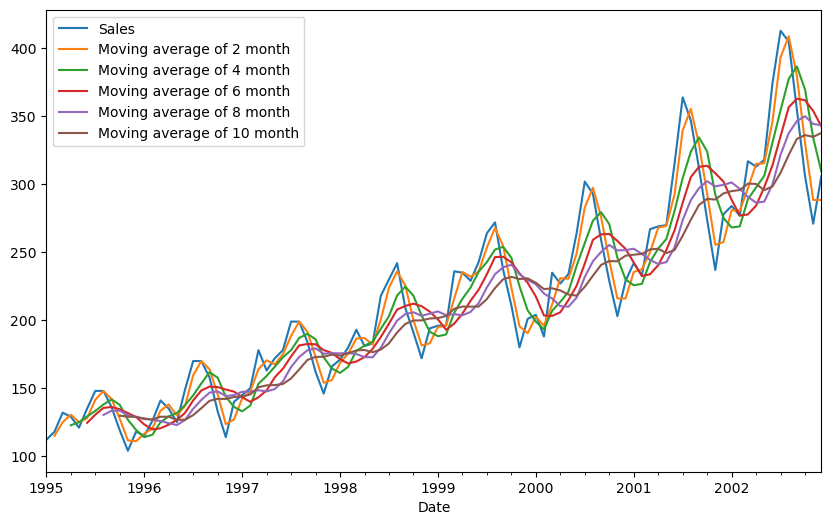

In [42]:
# plot the time series with rolling mean of 2 to 24 with step of 6 months
fig,ax = plt.subplots()
df['Passengers'].plot(ax = ax,label = 'Sales')
for i in range(2,12,2):\
    df['Passengers'].rolling(i).mean().plot(ax = ax,label = f'Moving average of {i} month')
ax.legend();

# The moving average upto 2 months is some what aligned with the data and able to capture the trend and seasonality, if the moving average is increased from 2 months the plot is not aligned with the actual value of the data

# Decomposition of time series into TREND , SEASONALITY and RESIDUAL

In [44]:
# Additive Decomposition plot
decomposition = seasonal_decompose(df['Passengers'],model='additive')

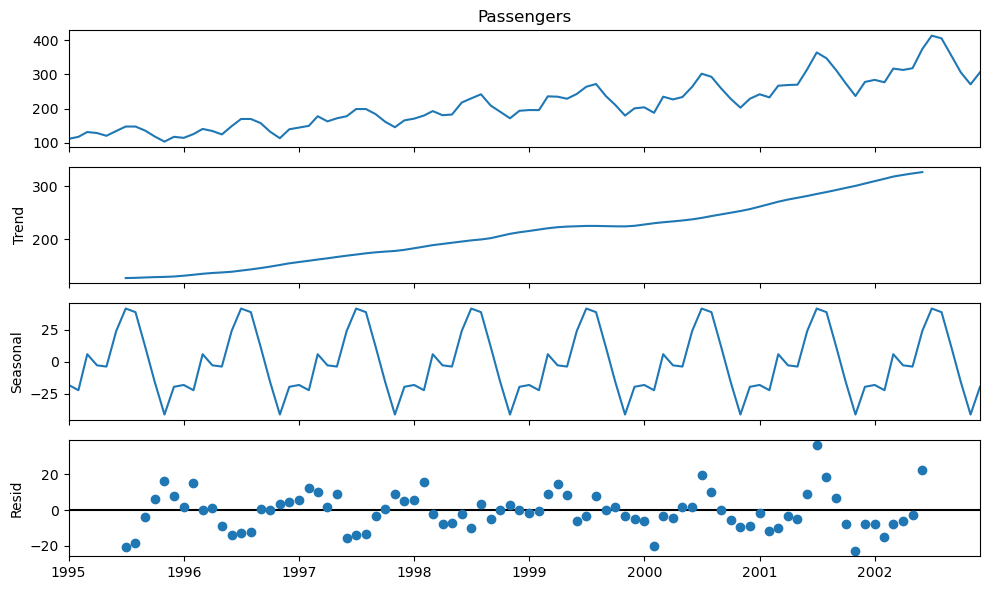

In [45]:
decomposition.plot();

# The residual values are on the both side of the value 0, There is a increase trend and seasonality in the data

In [47]:
# MULTIPLICATE DECOMPOSITION PLOT
season_multi = seasonal_decompose(df['Passengers'],model = 'multiplicative')

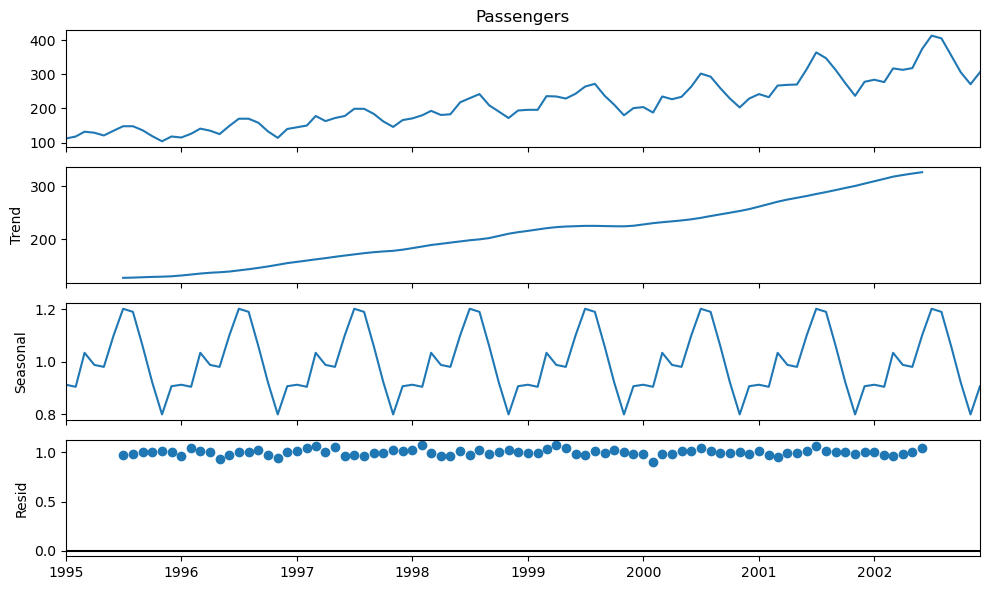

In [48]:
season_multi.plot();

# Auto Correltion plot - ACF and PACF

# The AutoCorrelation Function (ACF) plot is a graphical tool used in time series analysis to visualize the correlation of a series with its own past values at different lags. In other words, it shows how well the present value of a time series is related to its past values.

In [50]:
# Plot ACF using plot_acf
from statsmodels.graphics.tsaplots import plot_acf

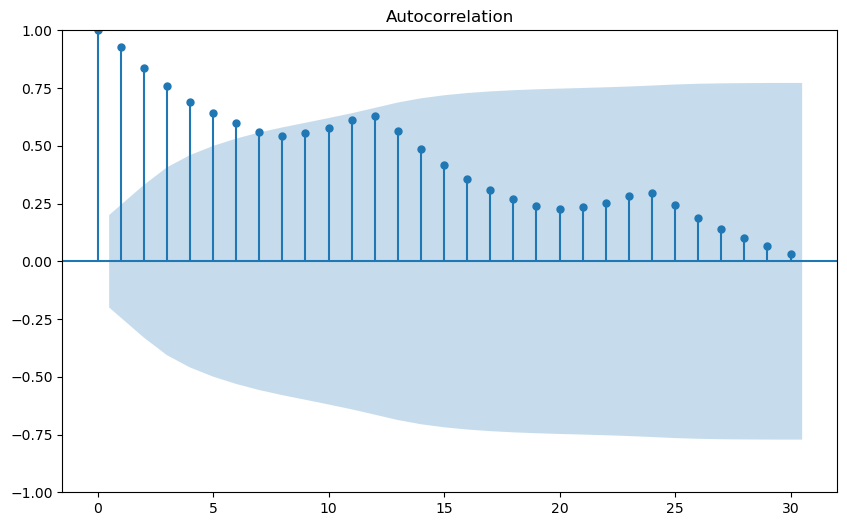

In [51]:
# Plotting the auto correlation plot
plot_acf(df['Passengers'],lags = 30);

# Plotting the PACF plot

In [52]:
# Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf

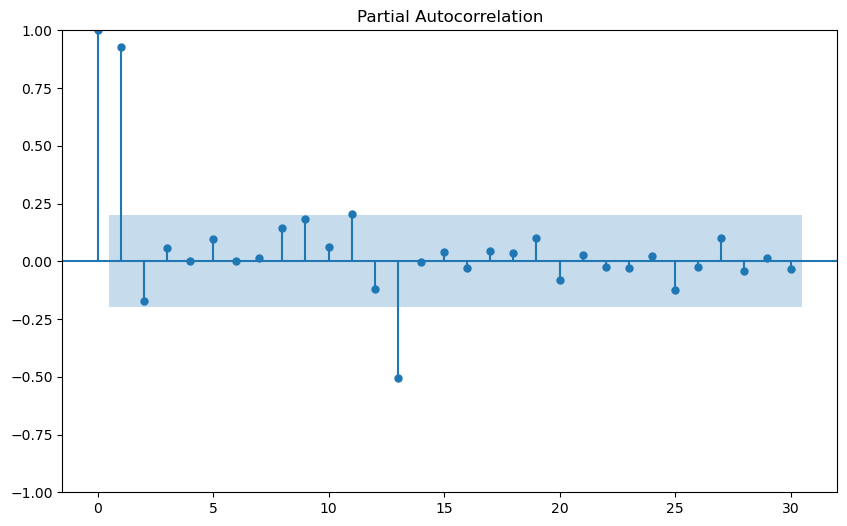

In [53]:
plot_pacf(df['Passengers'],lags = 30);

# The Partial AutoCorrelation Function (PACF) is a statistical method used in time series analysis to analyze the relationship between an observation and its lagged values, while taking into account the effect of the intervening observations. In other words, PACF measures the correlation between a time series and its own lag, controlling for the values of the time series at all shorter lags.

# Split the data into train and test.We are going to forecast the sales for 2 years so we will include 2 years data in the test data

In [54]:
train = df.iloc[:72]
test = df.iloc[72:]

In [55]:
train.shape,test.shape

((72, 15), (24, 15))

In [56]:
train.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep  
Date                            
1995-01-01    0    0    0    0  
1995-02-01    0    0    0    0  
1995-03-01    0    0    0    0  
1995-04-01    0    0    0    0  
1995-05-01    1    0    0    0

In [57]:
train.tail()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
2000-08-01         293   Aug  2000    0    1    0    0    0    0    0    0   
2000-09-01         259   Sep  2000    0    0    0    0    0    0    0    0   
2000-10-01         229   Oct  2000    0    0    0    0    0    0    0    0   
2000-11-01         203   Nov  2000    0    0    0    0    0    0    0    0   
2000-12-01         229   Dec  2000    0    0    1    0    0    0    0    0   

            May  Nov  Oct  Sep  
Date                            
2000-08-01    0    0    0    0  
2000-09-01    0    0    0    1  
2000-10-01    0    0    1    0  
2000-11-01    0    1    0    0  
2000-12-01    0    0    0    0

In [58]:
test.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
2001-01-01         242   Jan  2001    0    0    0    0    1    0    0    0   
2001-02-01         233   Feb  2001    0    0    0    1    0    0    0    0   
2001-03-01         267   Mar  2001    0    0    0    0    0    0    0    1   
2001-04-01         269   Apr  2001    1    0    0    0    0    0    0    0   
2001-05-01         270   May  2001    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep  
Date                            
2001-01-01    0    0    0    0  
2001-02-01    0    0    0    0  
2001-03-01    0    0    0    0  
2001-04-01    0    0    0    0  
2001-05-01    1    0    0    0

In [59]:
test.tail()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
2002-08-01         405   Aug  2002    0    1    0    0    0    0    0    0   
2002-09-01         355   Sep  2002    0    0    0    0    0    0    0    0   
2002-10-01         306   Oct  2002    0    0    0    0    0    0    0    0   
2002-11-01         271   Nov  2002    0    0    0    0    0    0    0    0   
2002-12-01         306   Dec  2002    0    0    1    0    0    0    0    0   

            May  Nov  Oct  Sep  
Date                            
2002-08-01    0    0    0    0  
2002-09-01    0    0    0    1  
2002-10-01    0    0    1    0  
2002-11-01    0    1    0    0  
2002-12-01    0    0    0    0

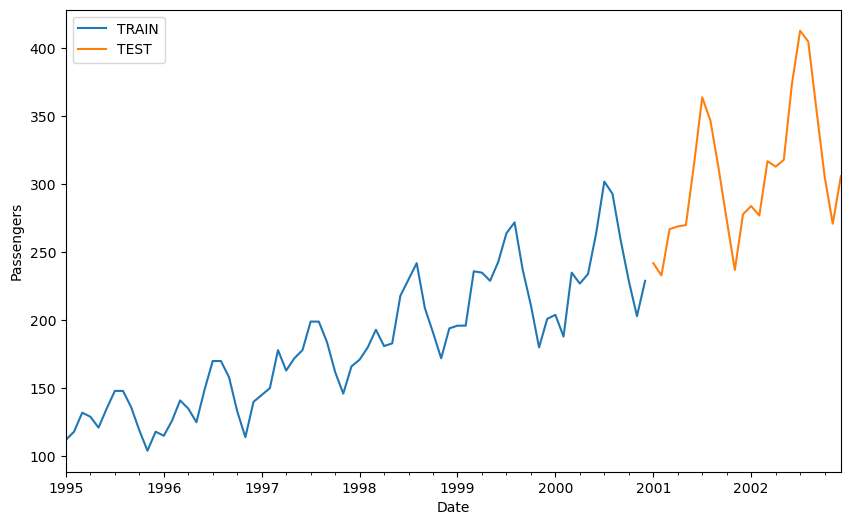

In [60]:
# Plot the train and test data
plt.xlabel('Date')
plt.ylabel('Passengers')
train['Passengers'].plot(legend = True,label = 'TRAIN')
test['Passengers'].plot(legend= True , label ='TEST');

# EXPONENTIAL MODELS

# Simple Exponential smooting model

In [61]:
# train a SES model on the train set and predict the values an the test set and plot train, test and predict values
ses_model = SimpleExpSmoothing(train['Passengers']).fit()
ses_predict = ses_model.predict(start = test.index[0],end = test.index[-1])

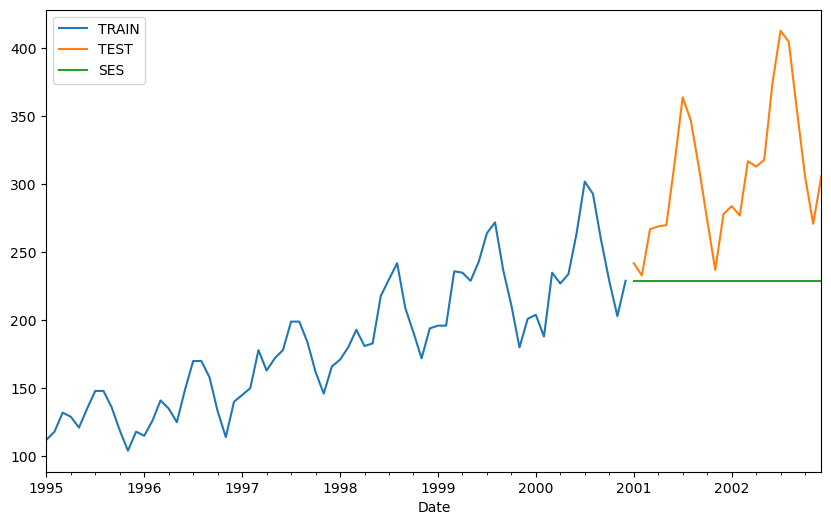

In [63]:
# Plot the values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
ses_predict.plot(legend= True,label = 'SES');

In [65]:
# Calculate rmse
rmse_ses = rmse(test['Passengers'],ses_predict)
rmse_ses

91.11325402904403

In [67]:
test['Passengers'].mean()

306.125

In [68]:
91.2*100/307

29.706840390879478

# The model is mot able to follow either trend os seasonality  Perhaps it is a straight line and RMSE of the model is also very high

# HOLT or DOUBLE EXPONENTIAL SMOOTHING MODEL

In [69]:
# import the exponential smmothing model from statsmodels
from statsmodels.tsa.api import Holt,ExponentialSmoothing,SimpleExpSmoothing
model_holt = Holt(train['Passengers']).fit()
predict_holt = model_holt.predict(start = test.index[0],end = test.index[-1])

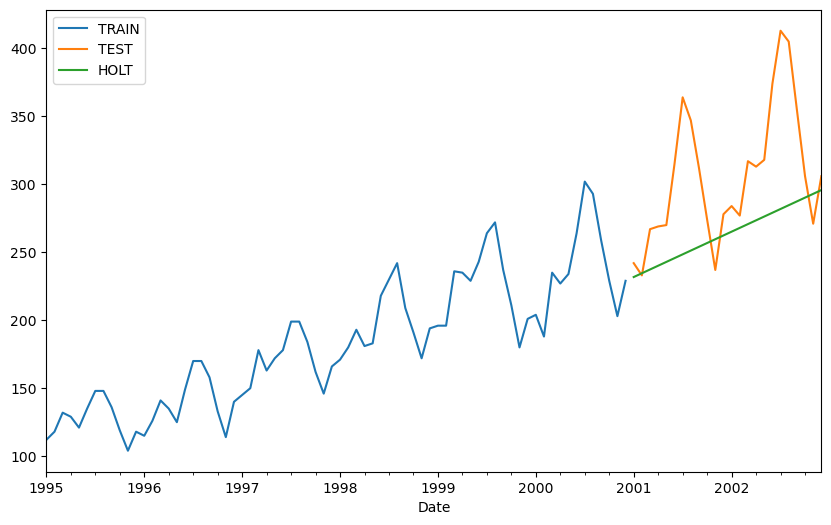

In [70]:
# plot the train,test and predicted values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
predict_holt.plot(legend = True, label = 'HOLT');

In [71]:
# CALCULATE RMSE
rmse_holt = rmse(test['Passengers'],predict_holt)
rmse_holt

59.951257094902374

In [72]:
test['Passengers'].mean()

306.125

In [73]:
60*100/306.2

19.59503592423253

# The model is able to capture the trend which is increasing but it is not able to capture the seasonality and on the other side the RMSE of the model is also very high

# HOLT winter model (Triple exponential smoothing)

# Holt winter model with additive trend and seasonality

In [74]:
model_hw_add = ExponentialSmoothing(train['Passengers'],trend = 'add',seasonal='add',
                                seasonal_periods=12).fit()
predict_hw_add = model_hw_add.predict(test.index[0],test.index[-1])

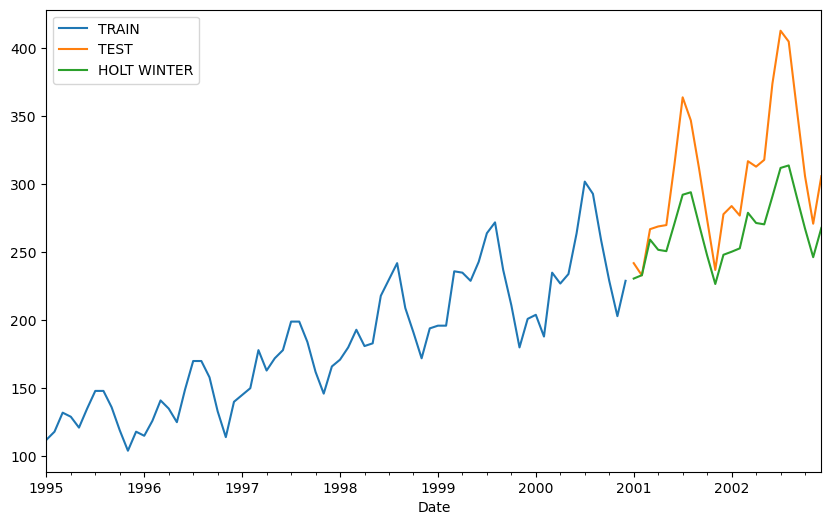

In [76]:
# Plot the train, test and predicted values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
predict_hw_add.plot(legend = True,label = 'HOLT WINTER');

In [77]:
# Calculate RMSE
rmse_hw_add = rmse(test['Passengers'],predict_hw_add)
rmse_hw_add

47.568386687074444

In [78]:
test['Passengers'].mean()

306.125

In [79]:
47.6*100/306.2

15.545395166557807

# The model is able to capture the trend and seasonality but not upto the mark and RMSE on the other side is also more

# Holt winter model with multiplicative seasonality and additive trend

In [80]:
model_hw_add_mul = ExponentialSmoothing(train['Passengers'],trend = 'add',seasonal='mul',
                                seasonal_periods=12).fit()
predict_hw_add_mul = model_hw_add_mul.predict(test.index[0],test.index[-1])

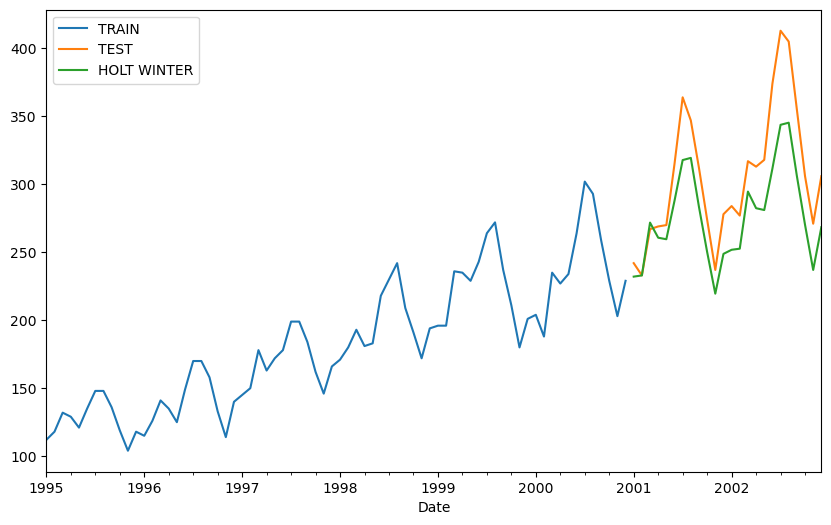

In [81]:
# Plot the train, test and predicted values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
predict_hw_add_mul.plot(legend = True,label = 'HOLT WINTER');

In [82]:
# Calculate RMSE
rmse_hw_add_mul = rmse(test['Passengers'],predict_hw_add_mul)
rmse_hw_add_mul

34.989261787209976

In [83]:
test['Passengers'].mean()

306.125

In [84]:
35*100/306.2

11.430437622468975

# The Exponential model with additive trend and multiplicative seasonality is sofar the better model and RMSE is not upto the mark . We will try other models and compare

# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [85]:
model_hw_mul_add = ExponentialSmoothing(train['Passengers'],trend = 'mul',seasonal='add',
                                seasonal_periods=12).fit()
predict_hw_mul_add = model_hw_mul_add.predict(test.index[0],test.index[-1])

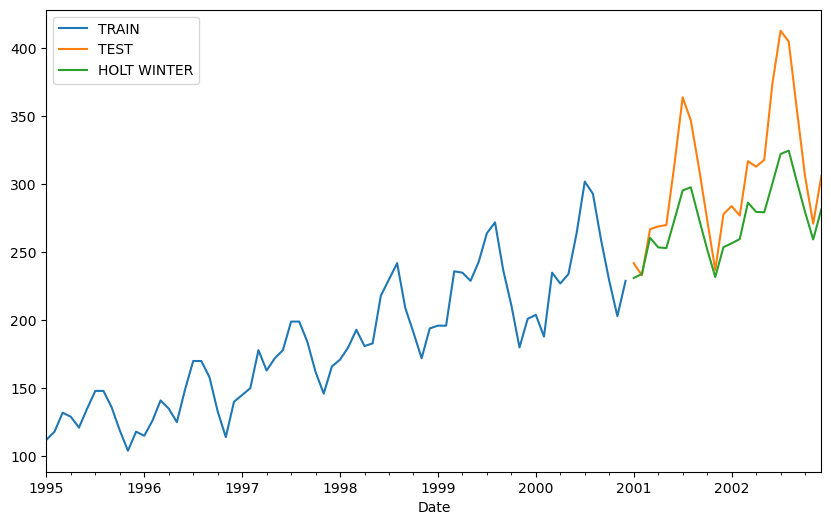

In [86]:
# Plot the train, test and predicted values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
predict_hw_mul_add.plot(legend = True,label = 'HOLT WINTER');

In [87]:
# Calculate RMSE
rmse_hw_mul_add = rmse(test['Passengers'],predict_hw_mul_add)
rmse_hw_mul_add

41.230939848848145

In [88]:
test['Passengers'].mean()

306.125

In [89]:
41.3*100/306.2

13.487916394513391

# The model performance is not upto the mark and RMSE also high

# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [90]:
model_hw_mul_mul = ExponentialSmoothing(train['Passengers'],trend = 'mul',seasonal='mul',
                                seasonal_periods=12).fit()
predict_hw_mul_mul = model_hw_mul_mul.predict(test.index[0],test.index[-1])

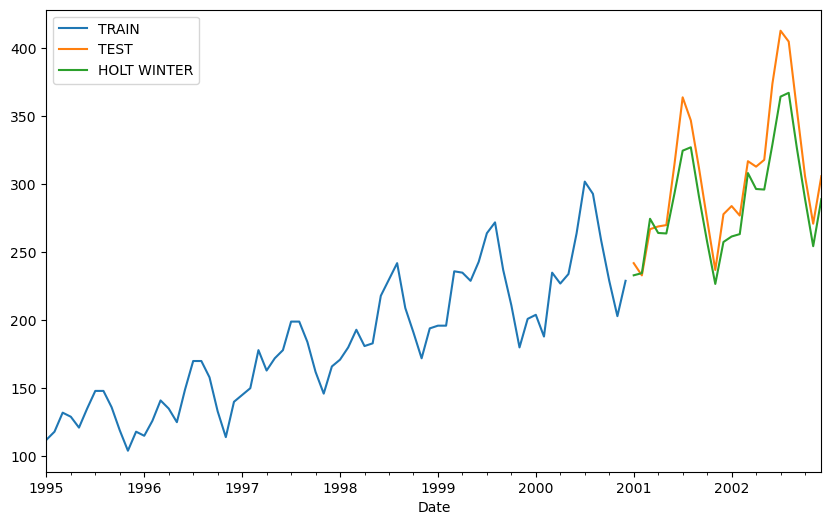

In [91]:
# Plot the train, test and predicted values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
predict_hw_mul_mul.plot(legend = True,label = 'HOLT WINTER');

In [92]:
# Calculate RMSE
rmse_hw_mul_mul = rmse(test['Passengers'],predict_hw_mul_mul)
rmse_hw_mul_mul

23.05878080418776

In [93]:
23.05*100/306.2

7.527759634225997

# So far the Triple Exponential smoothing model with multiplicative seasonalty and multiplicative trend is better model and it is able to capture the trend and seasonality also

# Hyper parameter tuning for different smoothing level,trend and seasonal values

In [94]:
smoothing_level_values = [0.1, 0.2, 0.3,0.4]
smoothing_trend_values = [0.1, 0.2, 0.3,0.4]
smoothing_seasonal_values = [0.1, 0.2, 0.3,0.4]


Parameters: alpha=0.1, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5944.731
Optimized:                         True   AIC                            349.779
Trend:                   Multiplicative   BIC                            386.205
Seasonal:                Multiplicative   AICC                           362.684
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:28
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

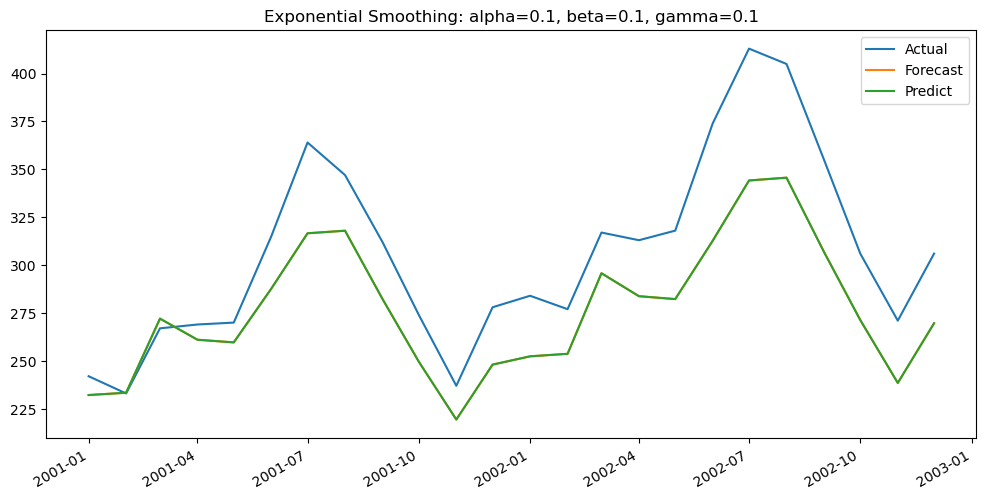


Parameters: alpha=0.1, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6331.146
Optimized:                         True   AIC                            354.313
Trend:                   Multiplicative   BIC                            390.740
Seasonal:                Multiplicative   AICC                           367.219
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:30
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

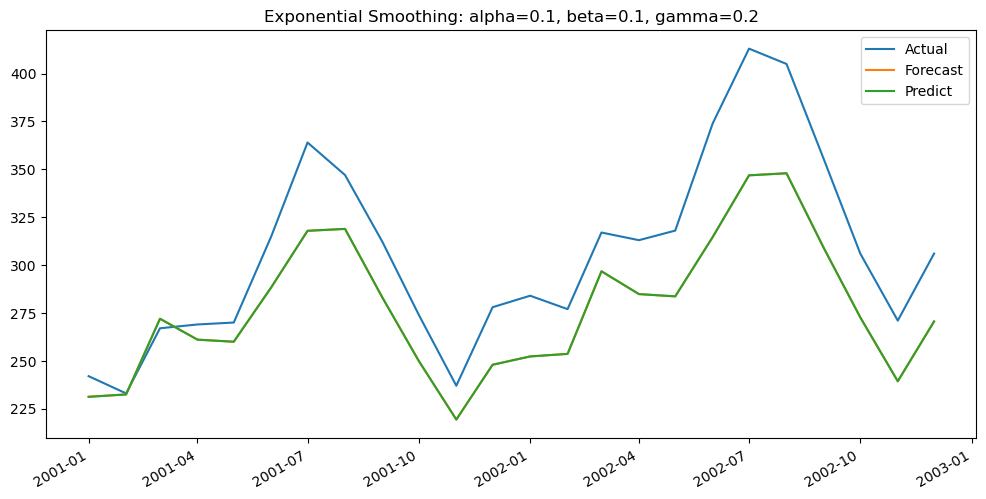


Parameters: alpha=0.1, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6650.727
Optimized:                         True   AIC                            357.859
Trend:                   Multiplicative   BIC                            394.285
Seasonal:                Multiplicative   AICC                           370.764
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

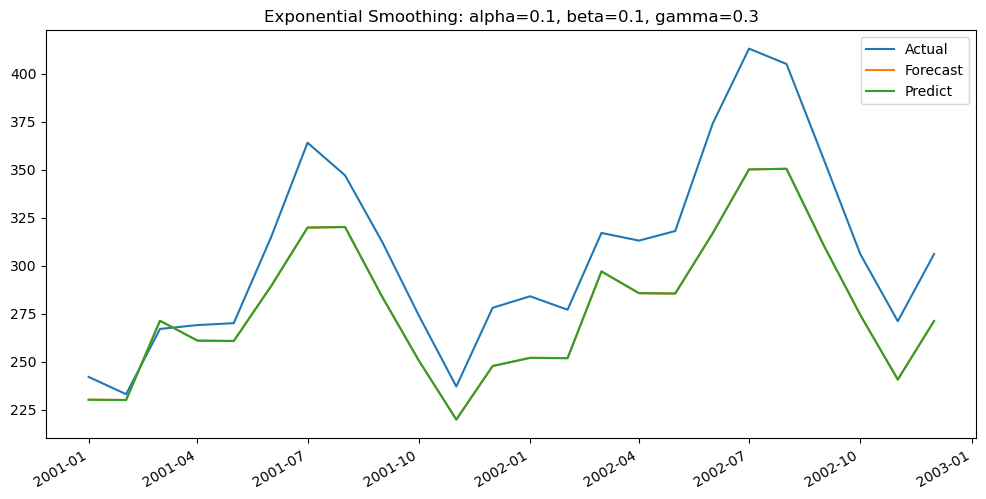


Parameters: alpha=0.1, beta=0.1, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6923.212
Optimized:                         True   AIC                            360.750
Trend:                   Multiplicative   BIC                            397.176
Seasonal:                Multiplicative   AICC                           373.655
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:33
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

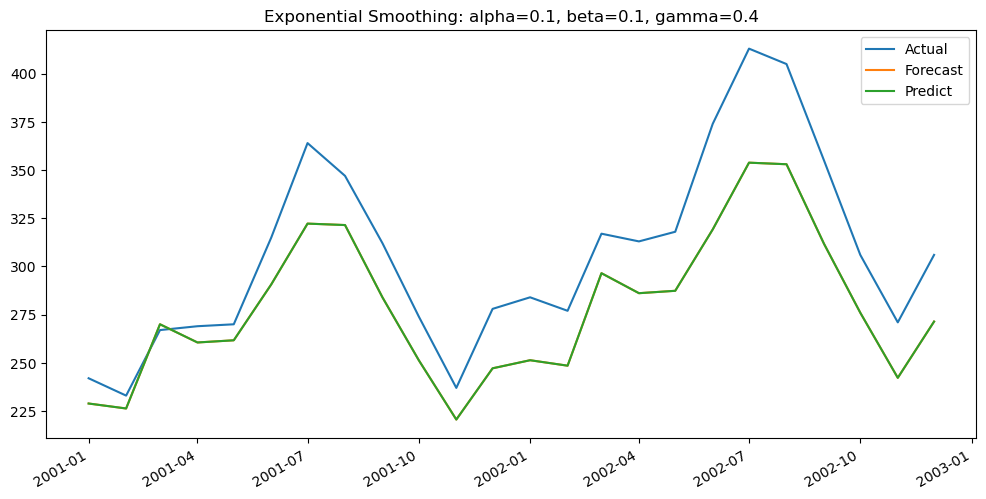


Parameters: alpha=0.1, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5970.646
Optimized:                         True   AIC                            350.092
Trend:                   Multiplicative   BIC                            386.519
Seasonal:                Multiplicative   AICC                           362.998
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

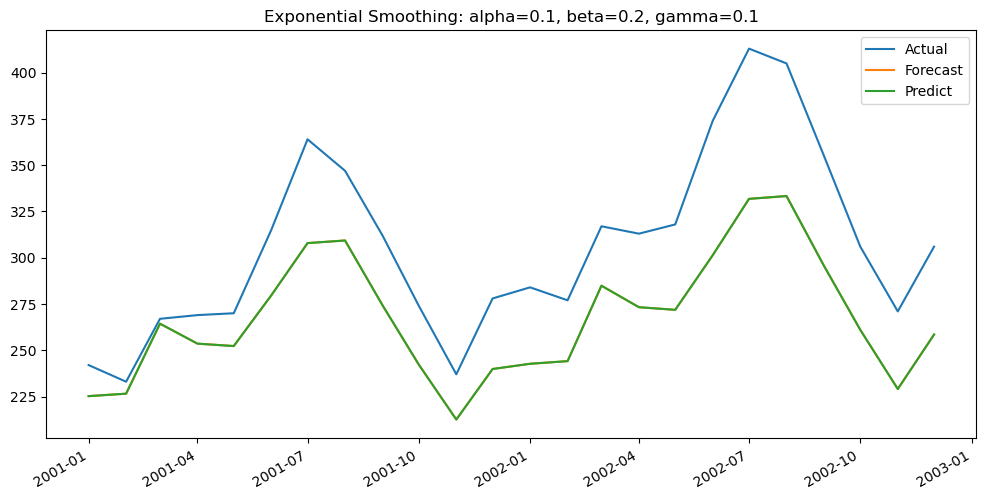


Parameters: alpha=0.1, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6498.108
Optimized:                         True   AIC                            356.187
Trend:                   Multiplicative   BIC                            392.614
Seasonal:                Multiplicative   AICC                           369.093
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

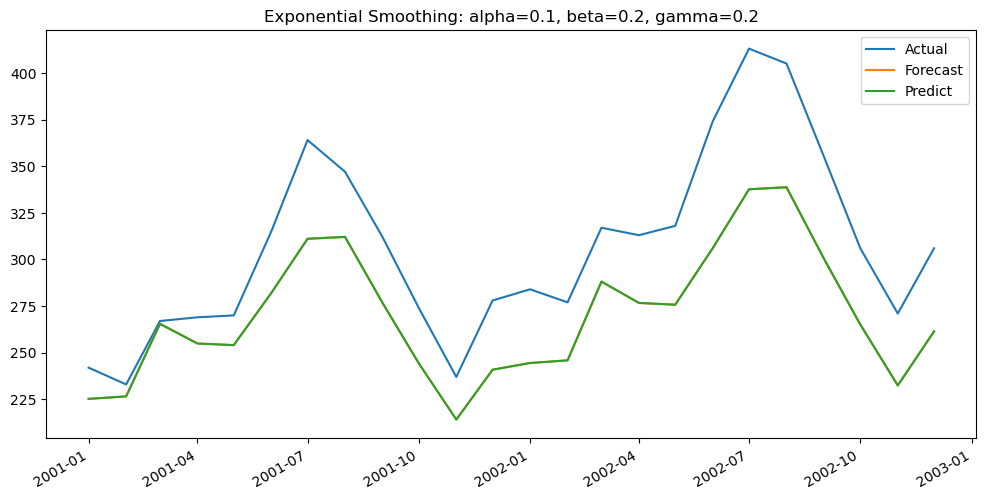


Parameters: alpha=0.1, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6978.206
Optimized:                         True   AIC                            361.319
Trend:                   Multiplicative   BIC                            397.746
Seasonal:                Multiplicative   AICC                           374.225
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:37
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

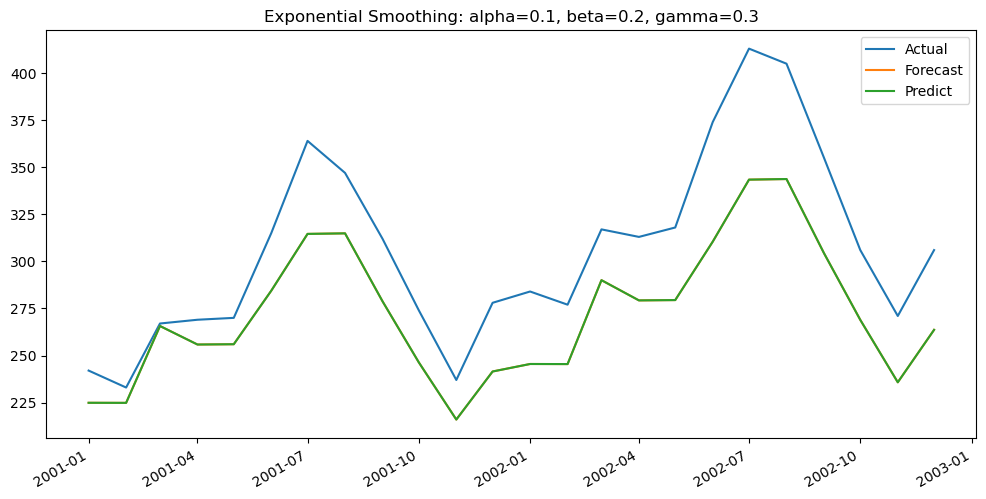


Parameters: alpha=0.1, beta=0.2, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7432.783
Optimized:                         True   AIC                            365.863
Trend:                   Multiplicative   BIC                            402.290
Seasonal:                Multiplicative   AICC                           378.769
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:39
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

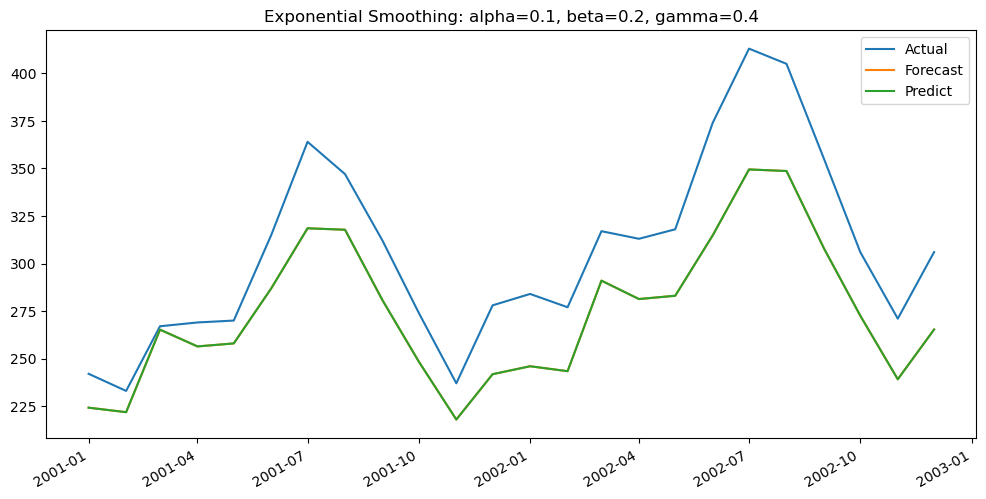


Parameters: alpha=0.1, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6326.488
Optimized:                         True   AIC                            354.260
Trend:                   Multiplicative   BIC                            390.687
Seasonal:                Multiplicative   AICC                           367.166
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

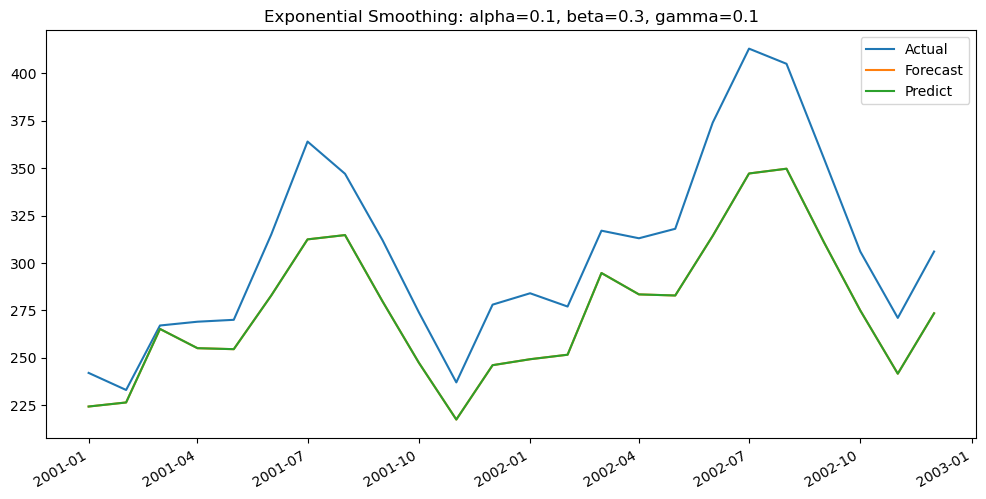


Parameters: alpha=0.1, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7057.167
Optimized:                         True   AIC                            362.130
Trend:                   Multiplicative   BIC                            398.556
Seasonal:                Multiplicative   AICC                           375.035
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

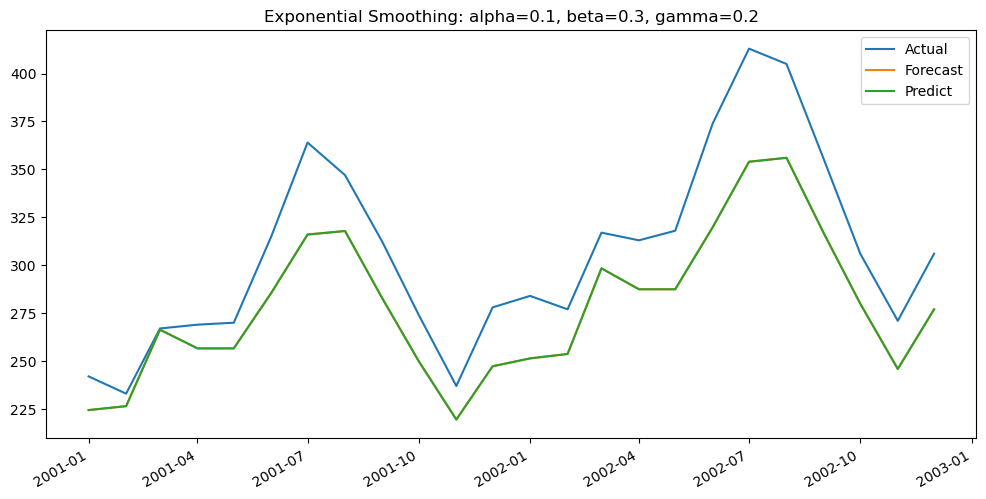


Parameters: alpha=0.1, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7751.038
Optimized:                         True   AIC                            368.882
Trend:                   Multiplicative   BIC                            405.309
Seasonal:                Multiplicative   AICC                           381.788
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:44
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

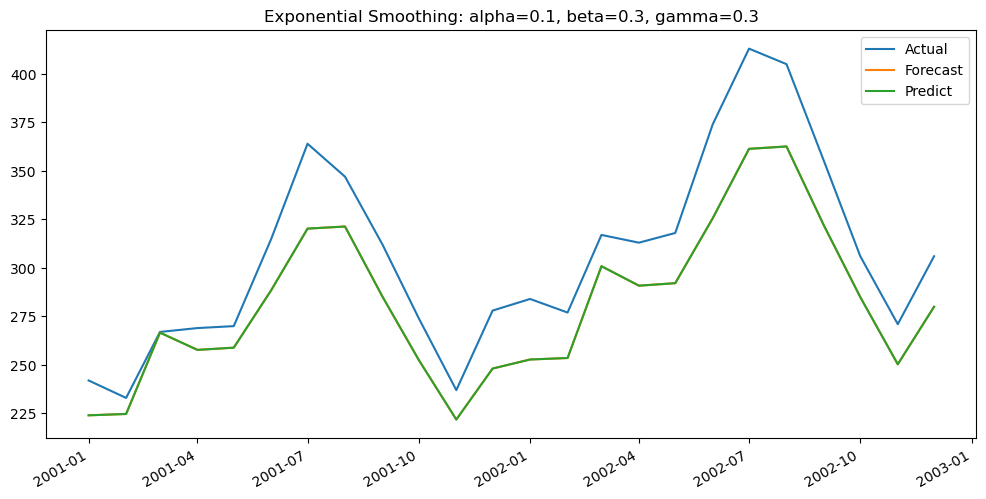


Parameters: alpha=0.1, beta=0.3, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           8430.696
Optimized:                         True   AIC                            374.934
Trend:                   Multiplicative   BIC                            411.360
Seasonal:                Multiplicative   AICC                           387.839
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

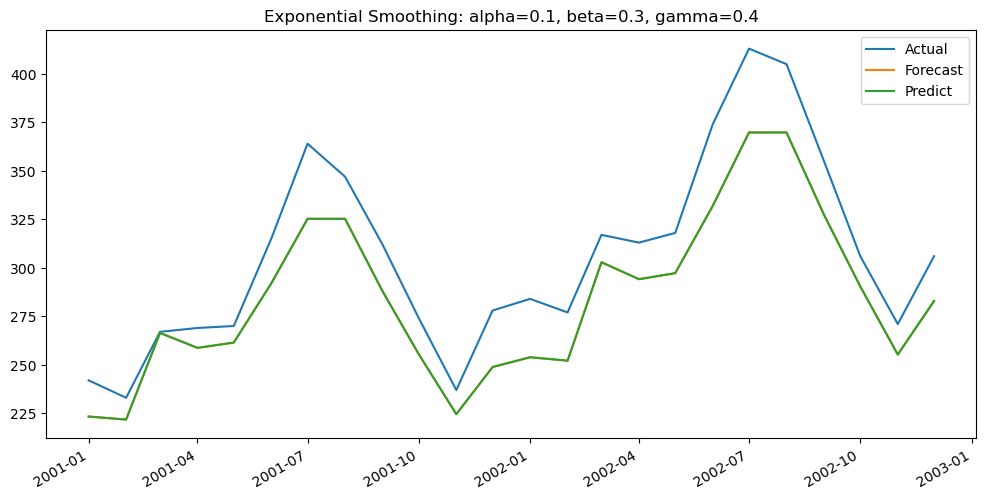


Parameters: alpha=0.1, beta=0.4, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7295.533
Optimized:                         True   AIC                            364.521
Trend:                   Multiplicative   BIC                            400.948
Seasonal:                Multiplicative   AICC                           377.427
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:46
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

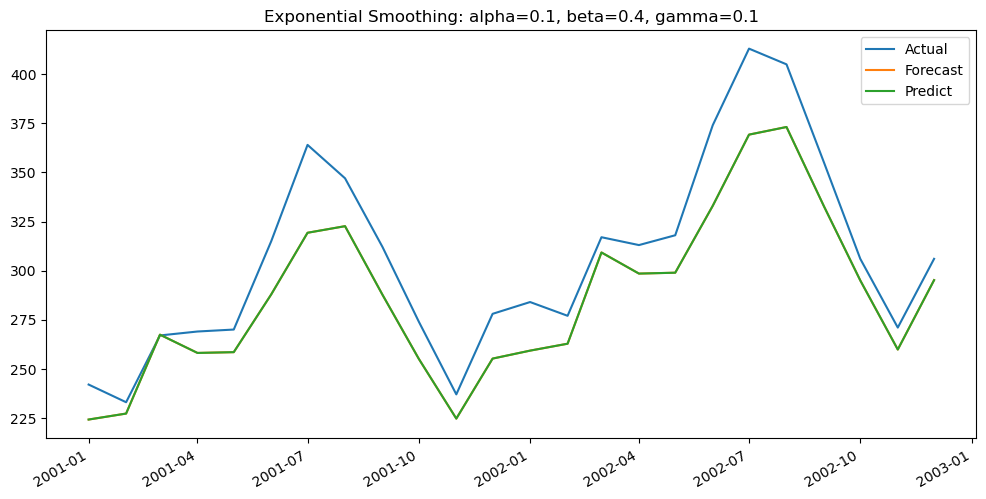


Parameters: alpha=0.1, beta=0.4, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           8185.466
Optimized:                         True   AIC                            372.808
Trend:                   Multiplicative   BIC                            409.235
Seasonal:                Multiplicative   AICC                           385.714
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:48
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

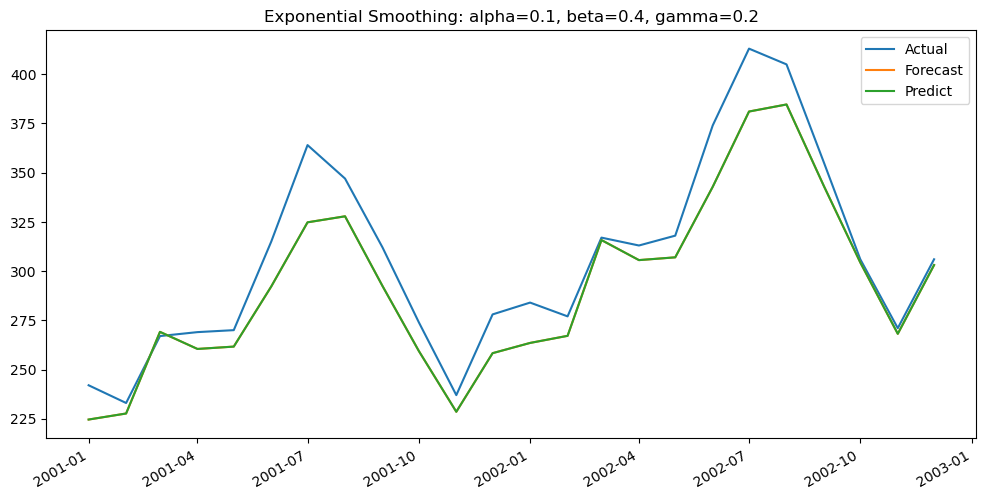


Parameters: alpha=0.1, beta=0.4, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           9022.051
Optimized:                         True   AIC                            379.815
Trend:                   Multiplicative   BIC                            416.241
Seasonal:                Multiplicative   AICC                           392.720
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:50
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

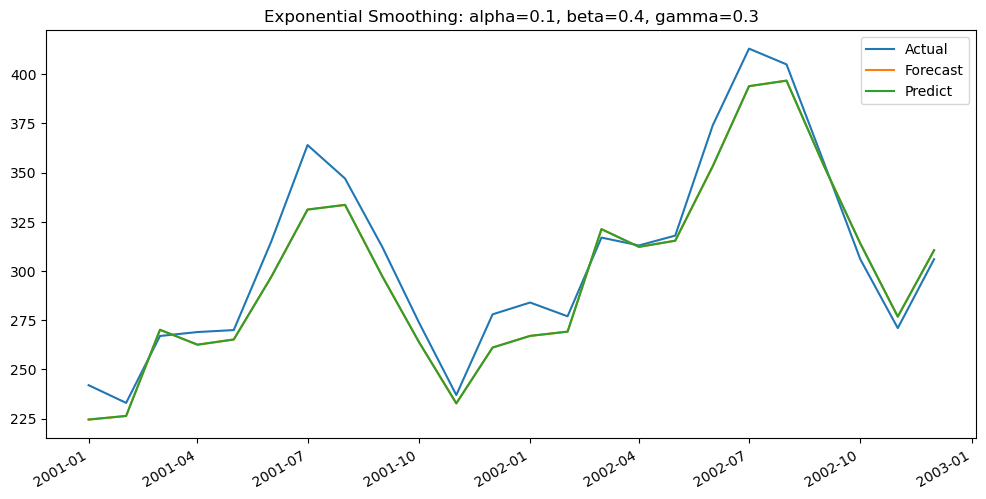


Parameters: alpha=0.1, beta=0.4, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           9819.913
Optimized:                         True   AIC                            385.916
Trend:                   Multiplicative   BIC                            422.343
Seasonal:                Multiplicative   AICC                           398.822
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:51
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

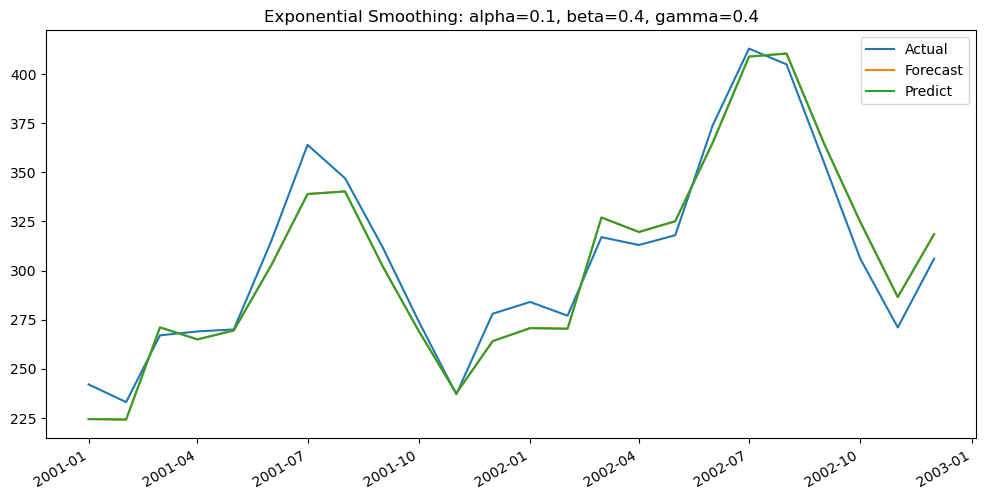


Parameters: alpha=0.2, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4815.727
Optimized:                         True   AIC                            334.614
Trend:                   Multiplicative   BIC                            371.041
Seasonal:                Multiplicative   AICC                           347.520
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:53
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

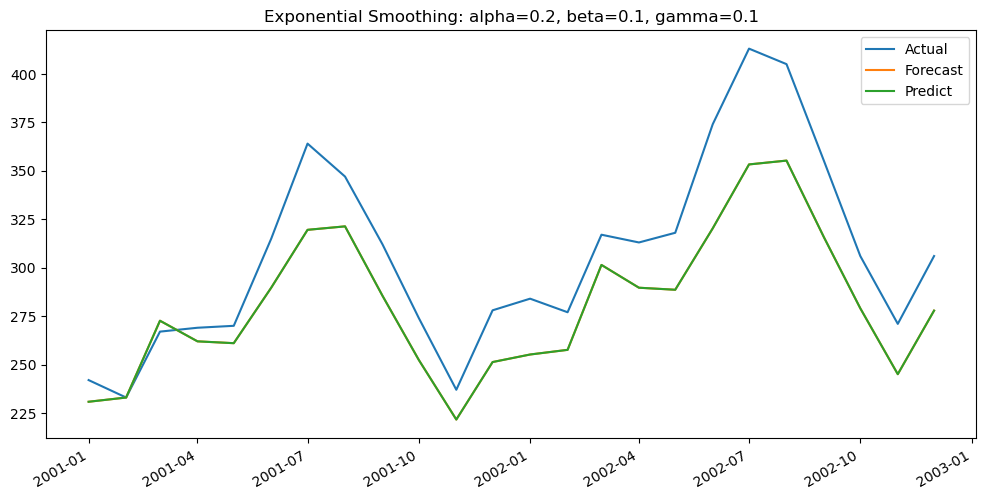


Parameters: alpha=0.2, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5256.114
Optimized:                         True   AIC                            340.915
Trend:                   Multiplicative   BIC                            377.341
Seasonal:                Multiplicative   AICC                           353.820
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:55
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

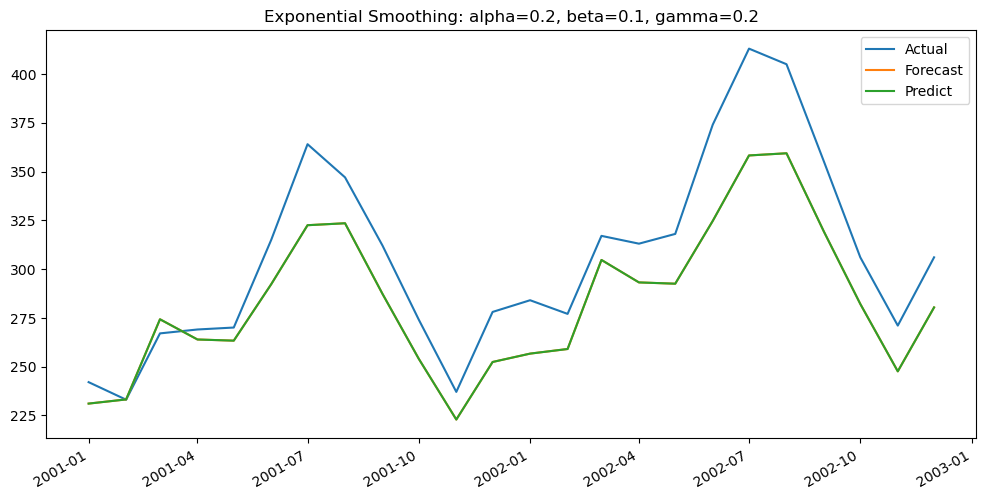


Parameters: alpha=0.2, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5637.104
Optimized:                         True   AIC                            345.953
Trend:                   Multiplicative   BIC                            382.380
Seasonal:                Multiplicative   AICC                           358.859
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:49:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

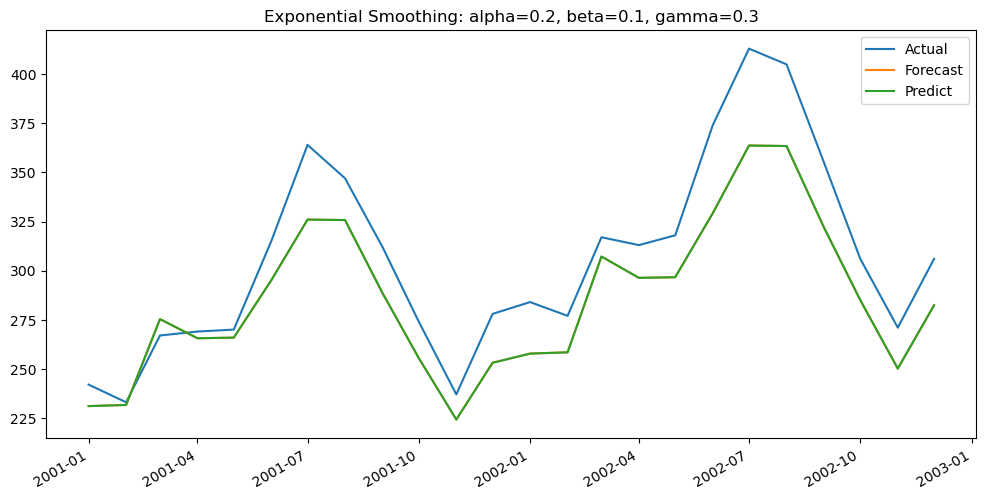


Parameters: alpha=0.2, beta=0.1, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5976.350
Optimized:                         True   AIC                            350.161
Trend:                   Multiplicative   BIC                            386.587
Seasonal:                Multiplicative   AICC                           363.066
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:02
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

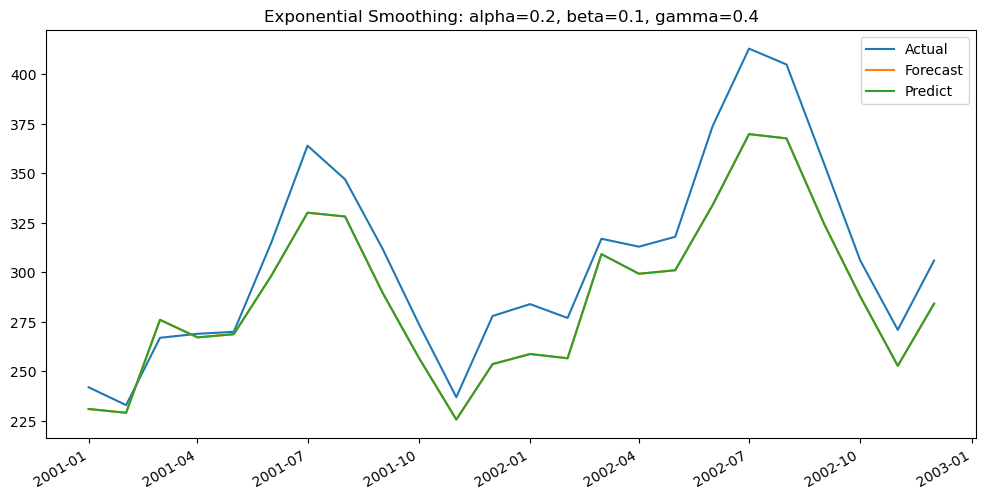


Parameters: alpha=0.2, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5420.190
Optimized:                         True   AIC                            343.128
Trend:                   Multiplicative   BIC                            379.555
Seasonal:                Multiplicative   AICC                           356.034
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:04
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

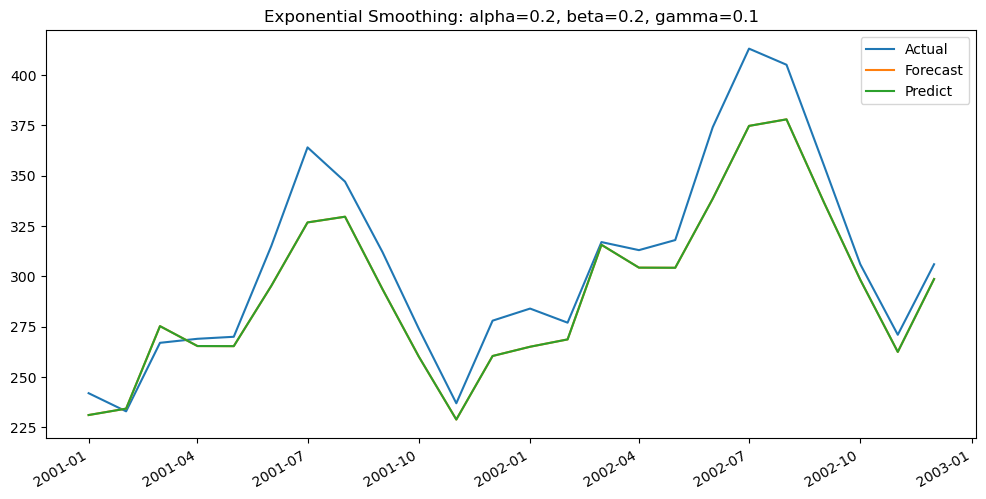


Parameters: alpha=0.2, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5948.083
Optimized:                         True   AIC                            349.819
Trend:                   Multiplicative   BIC                            386.246
Seasonal:                Multiplicative   AICC                           362.725
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

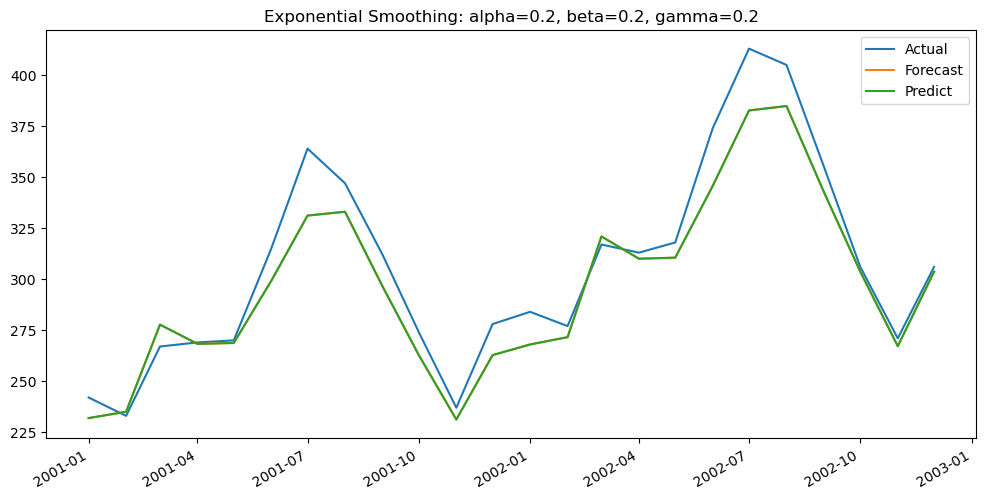


Parameters: alpha=0.2, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6412.678
Optimized:                         True   AIC                            355.234
Trend:                   Multiplicative   BIC                            391.661
Seasonal:                Multiplicative   AICC                           368.140
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

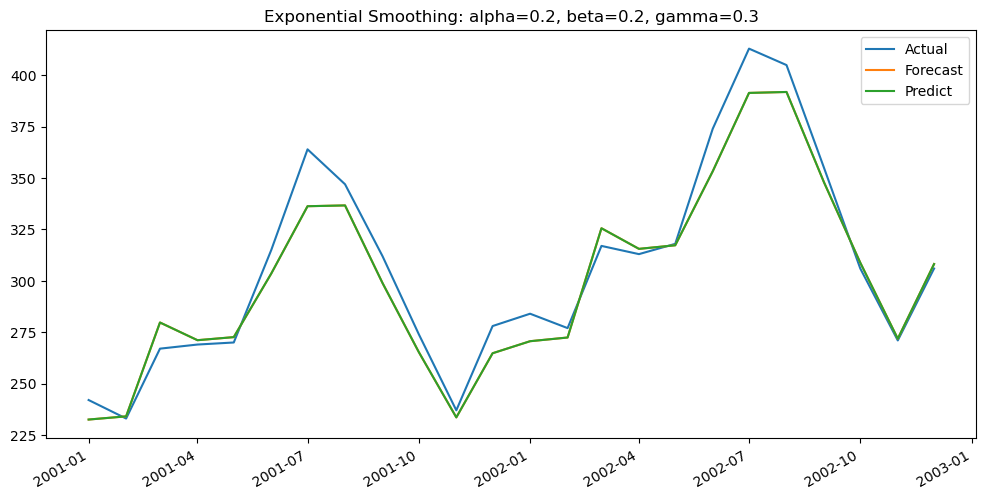


Parameters: alpha=0.2, beta=0.2, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6820.851
Optimized:                         True   AIC                            359.677
Trend:                   Multiplicative   BIC                            396.104
Seasonal:                Multiplicative   AICC                           372.583
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

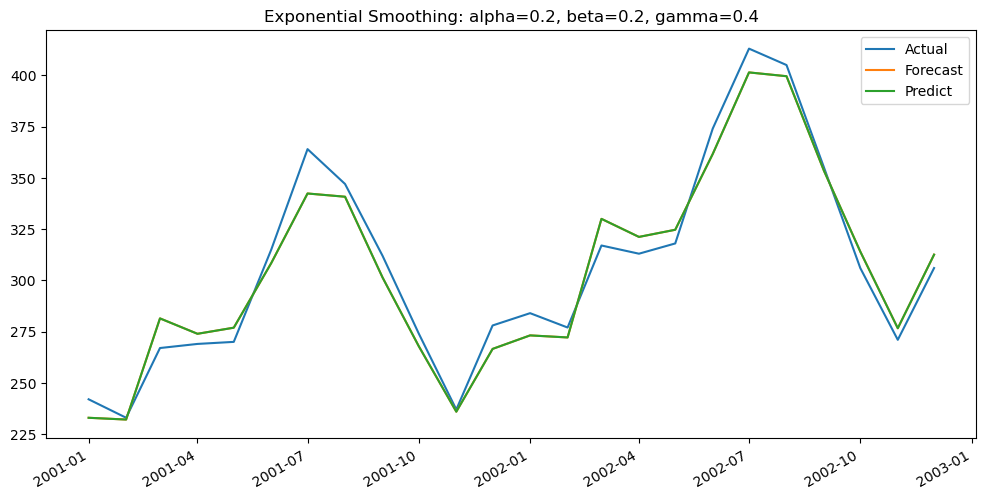


Parameters: alpha=0.2, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5960.287
Optimized:                         True   AIC                            349.967
Trend:                   Multiplicative   BIC                            386.394
Seasonal:                Multiplicative   AICC                           362.873
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

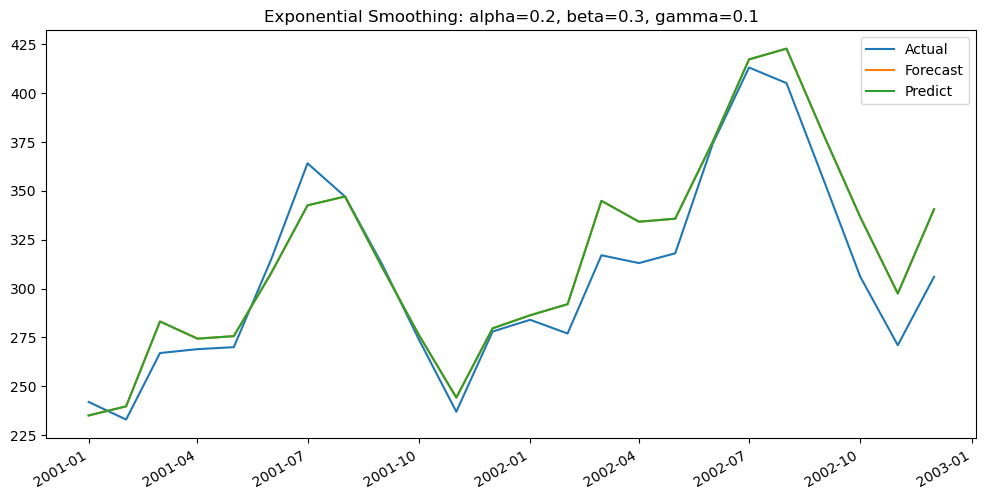


Parameters: alpha=0.2, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6507.500
Optimized:                         True   AIC                            356.291
Trend:                   Multiplicative   BIC                            392.718
Seasonal:                Multiplicative   AICC                           369.197
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

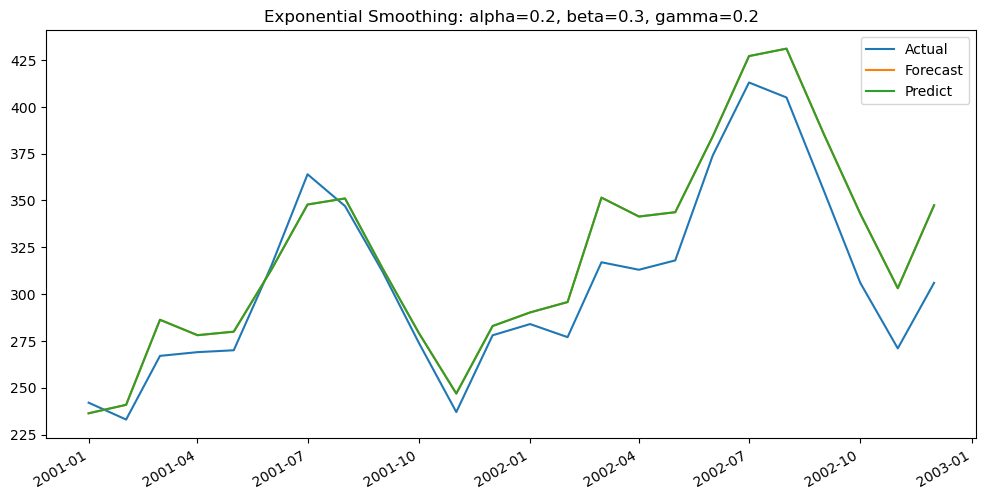


Parameters: alpha=0.2, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6968.366
Optimized:                         True   AIC                            361.218
Trend:                   Multiplicative   BIC                            397.644
Seasonal:                Multiplicative   AICC                           374.123
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:14
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

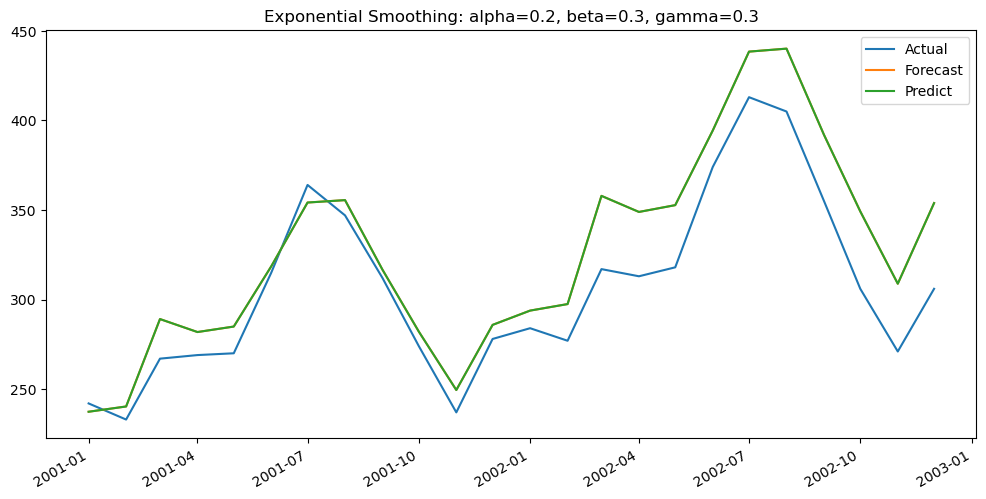


Parameters: alpha=0.2, beta=0.3, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7329.446
Optimized:                         True   AIC                            364.855
Trend:                   Multiplicative   BIC                            401.282
Seasonal:                Multiplicative   AICC                           377.761
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:15
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

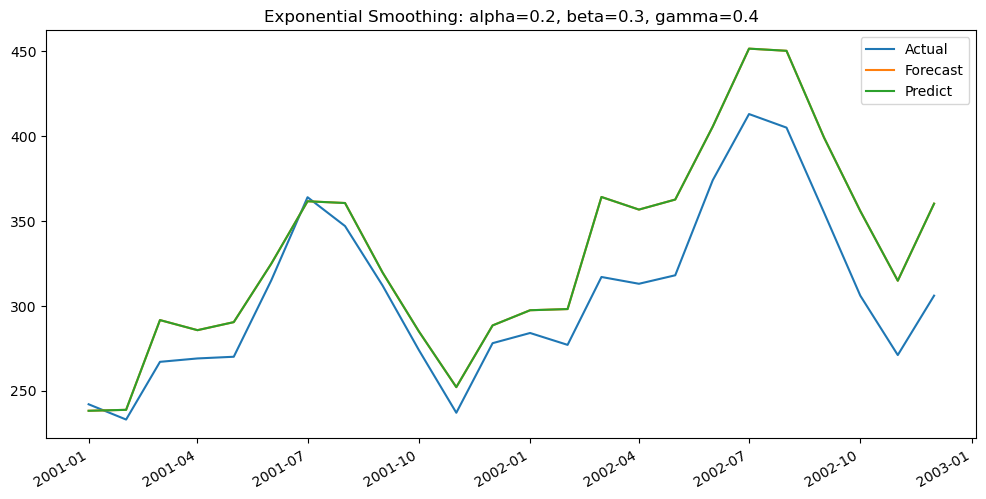


Parameters: alpha=0.2, beta=0.4, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6175.549
Optimized:                         True   AIC                            352.521
Trend:                   Multiplicative   BIC                            388.948
Seasonal:                Multiplicative   AICC                           365.427
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

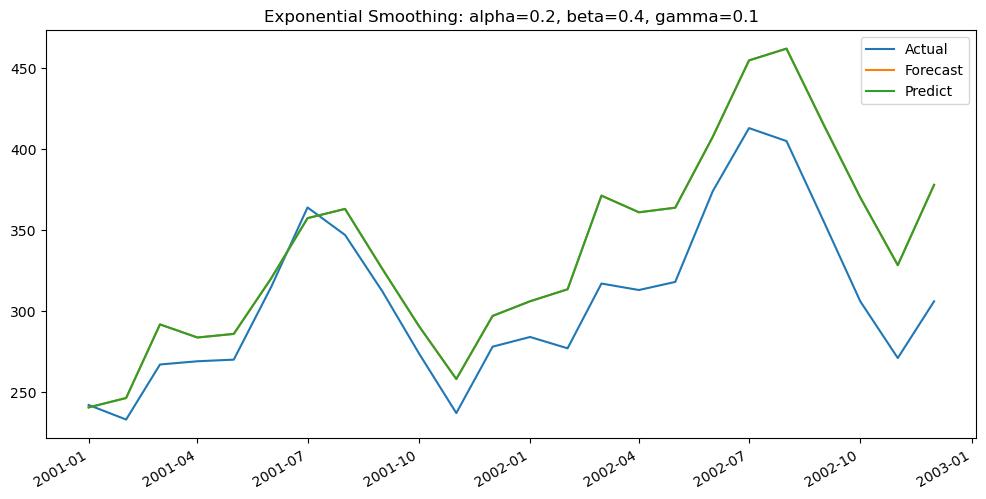


Parameters: alpha=0.2, beta=0.4, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6711.576
Optimized:                         True   AIC                            358.514
Trend:                   Multiplicative   BIC                            394.941
Seasonal:                Multiplicative   AICC                           371.420
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

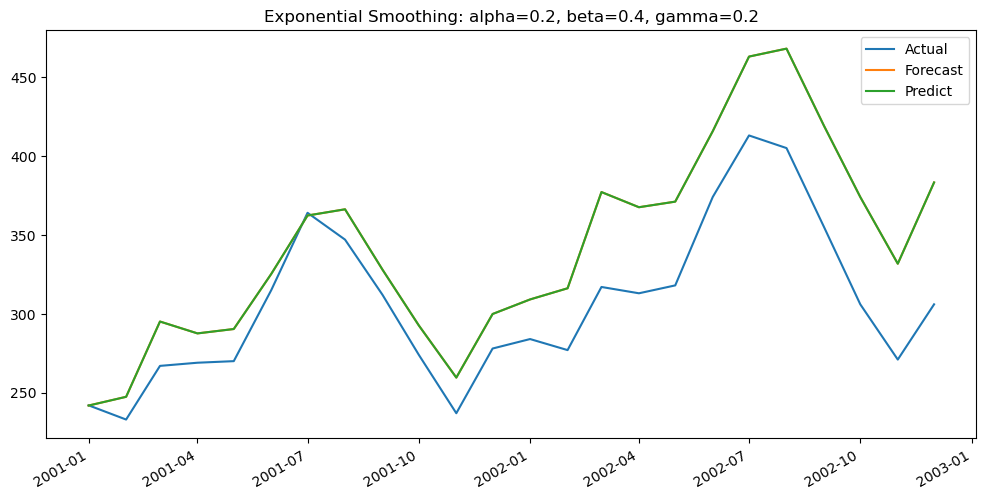


Parameters: alpha=0.2, beta=0.4, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7119.095
Optimized:                         True   AIC                            362.759
Trend:                   Multiplicative   BIC                            399.185
Seasonal:                Multiplicative   AICC                           375.664
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:20
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

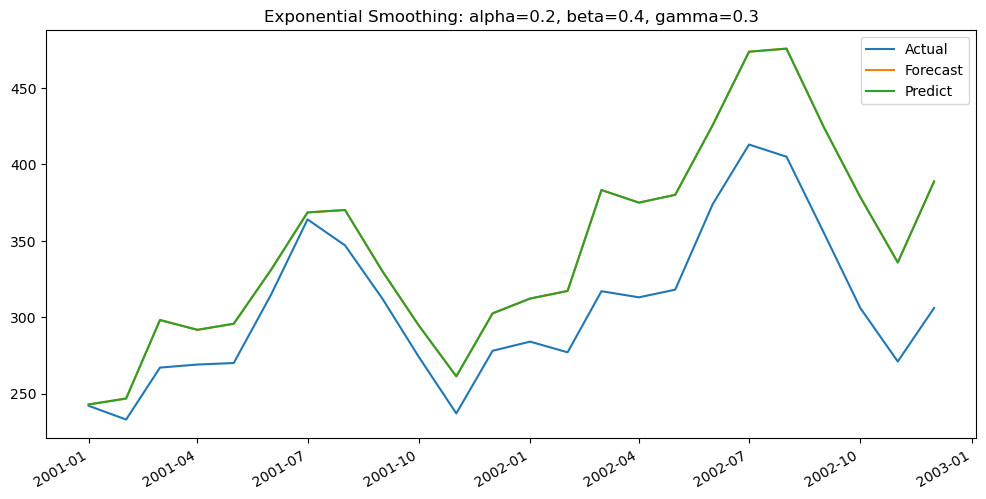


Parameters: alpha=0.2, beta=0.4, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7387.548
Optimized:                         True   AIC                            365.424
Trend:                   Multiplicative   BIC                            401.850
Seasonal:                Multiplicative   AICC                           378.329
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   

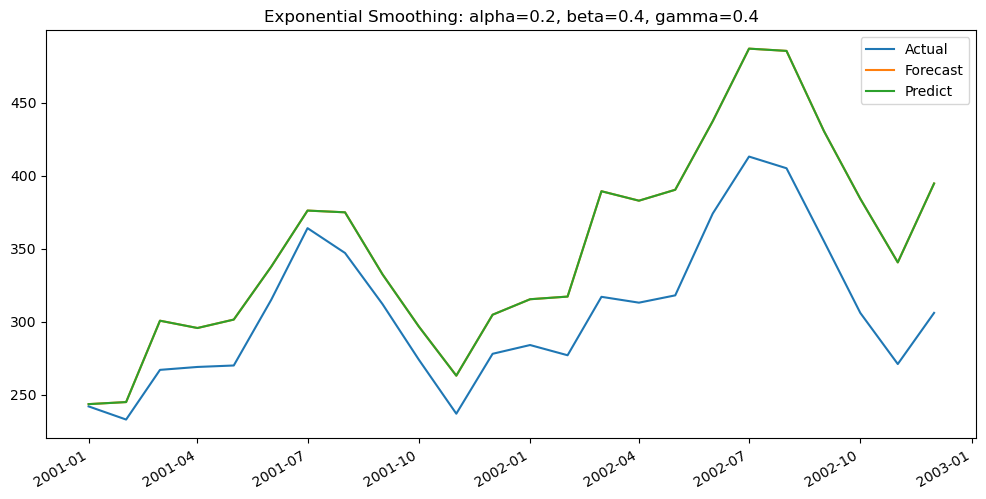


Parameters: alpha=0.3, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4287.622
Optimized:                         True   AIC                            326.251
Trend:                   Multiplicative   BIC                            362.678
Seasonal:                Multiplicative   AICC                           339.157
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

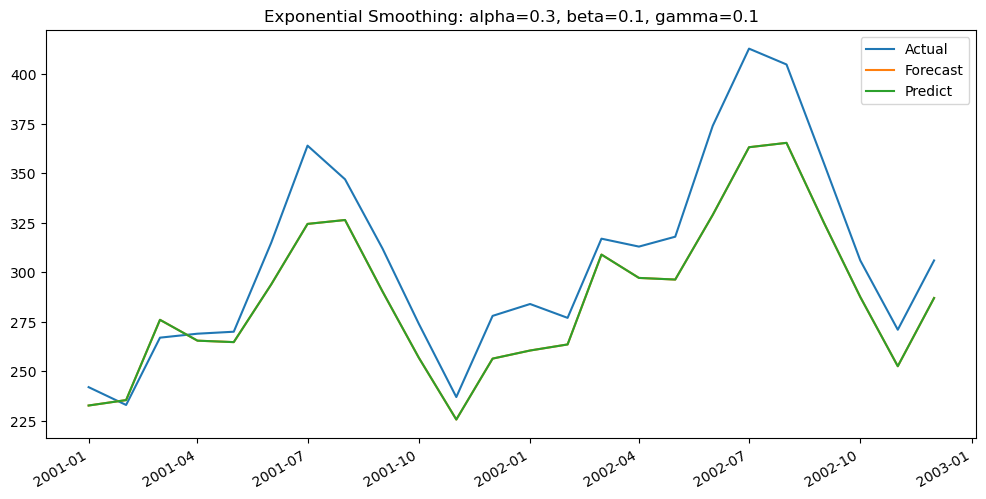


Parameters: alpha=0.3, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4691.021
Optimized:                         True   AIC                            332.725
Trend:                   Multiplicative   BIC                            369.152
Seasonal:                Multiplicative   AICC                           345.631
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

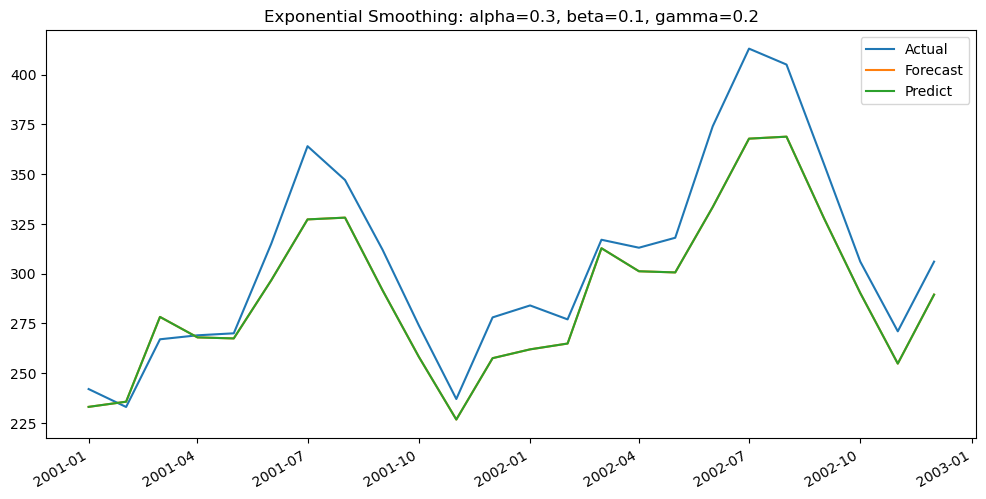


Parameters: alpha=0.3, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5035.166
Optimized:                         True   AIC                            337.823
Trend:                   Multiplicative   BIC                            374.249
Seasonal:                Multiplicative   AICC                           350.728
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:26
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

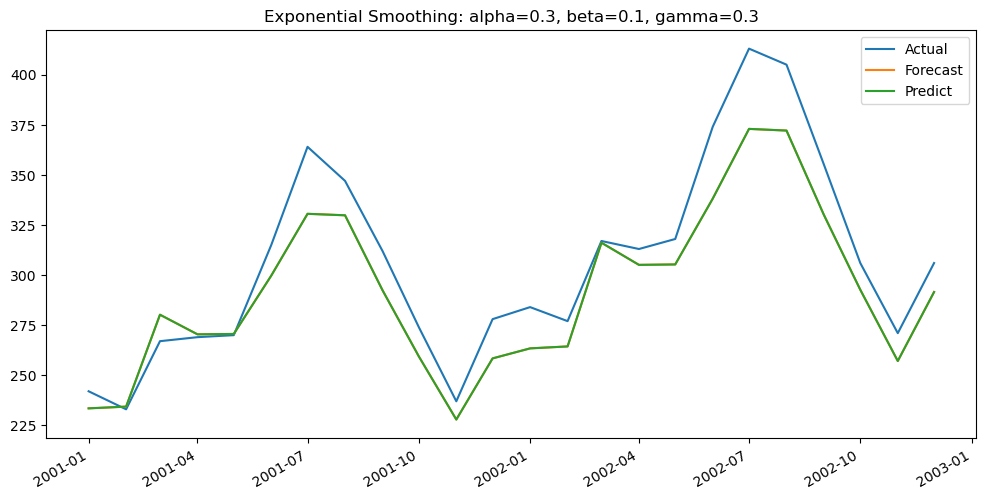


Parameters: alpha=0.3, beta=0.1, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5338.802
Optimized:                         True   AIC                            342.039
Trend:                   Multiplicative   BIC                            378.465
Seasonal:                Multiplicative   AICC                           354.944
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:27
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

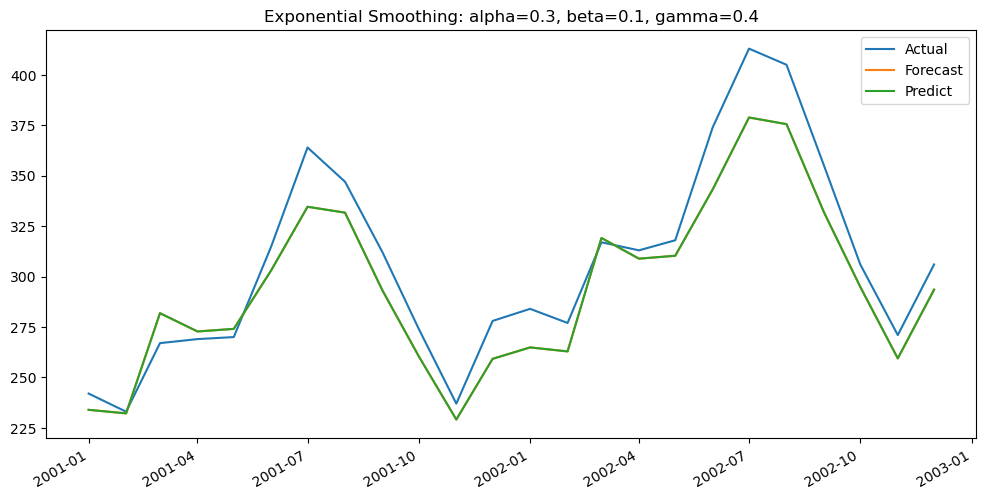


Parameters: alpha=0.3, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4692.521
Optimized:                         True   AIC                            332.748
Trend:                   Multiplicative   BIC                            369.175
Seasonal:                Multiplicative   AICC                           345.654
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

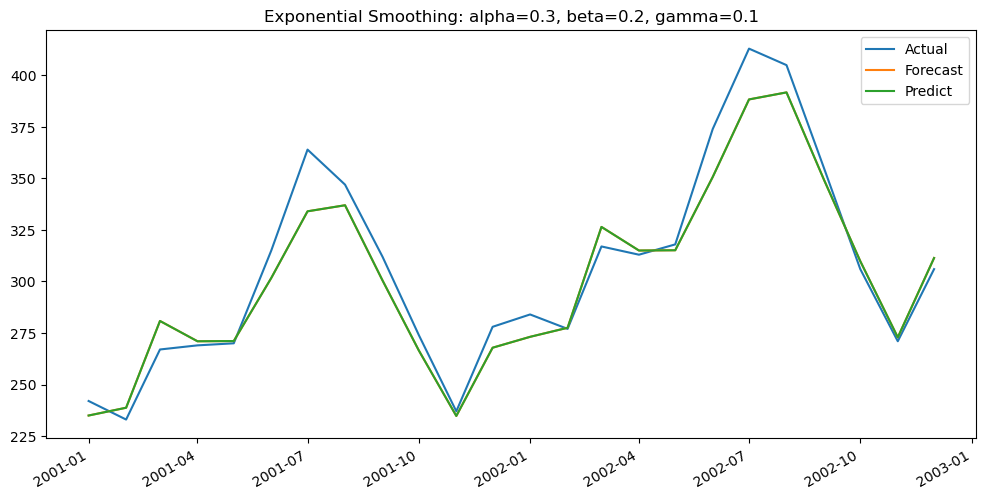


Parameters: alpha=0.3, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5129.217
Optimized:                         True   AIC                            339.155
Trend:                   Multiplicative   BIC                            375.582
Seasonal:                Multiplicative   AICC                           352.061
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

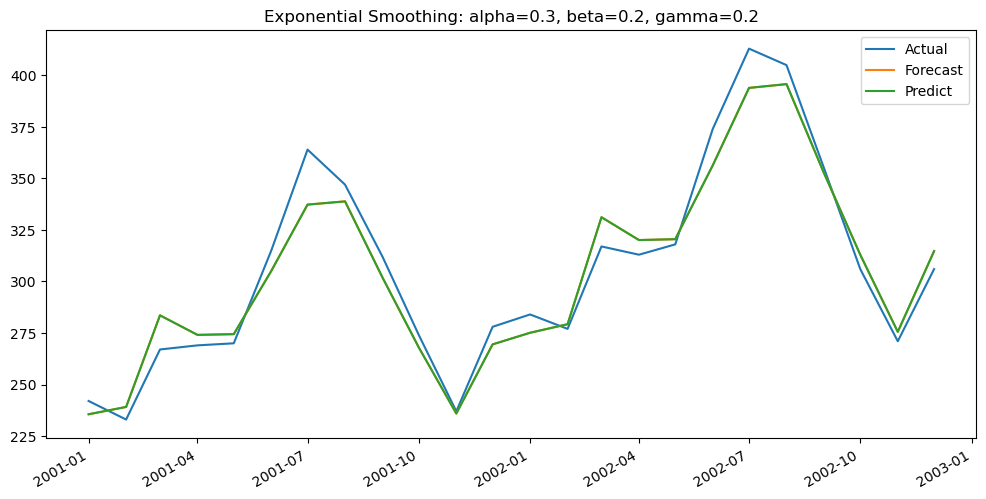


Parameters: alpha=0.3, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5496.398
Optimized:                         True   AIC                            344.133
Trend:                   Multiplicative   BIC                            380.560
Seasonal:                Multiplicative   AICC                           357.039
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:33
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

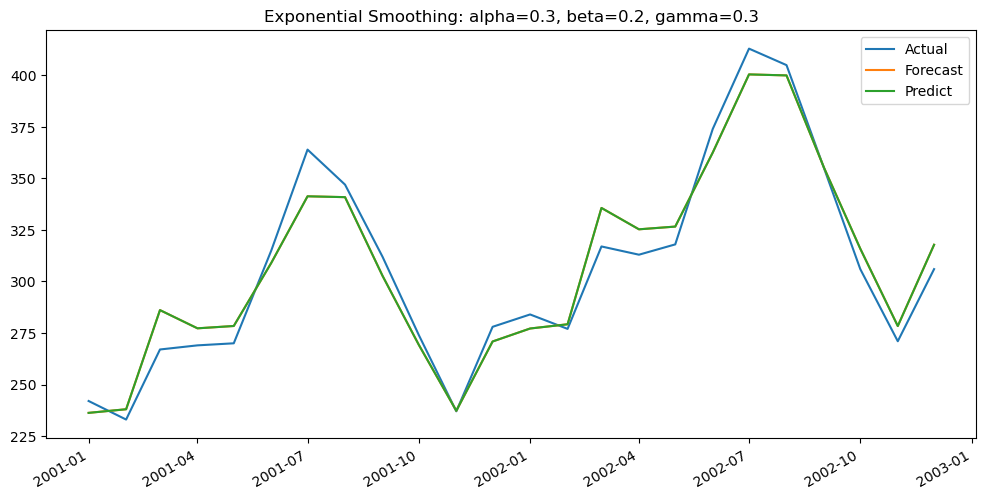


Parameters: alpha=0.3, beta=0.2, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5806.746
Optimized:                         True   AIC                            348.088
Trend:                   Multiplicative   BIC                            384.515
Seasonal:                Multiplicative   AICC                           360.994
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

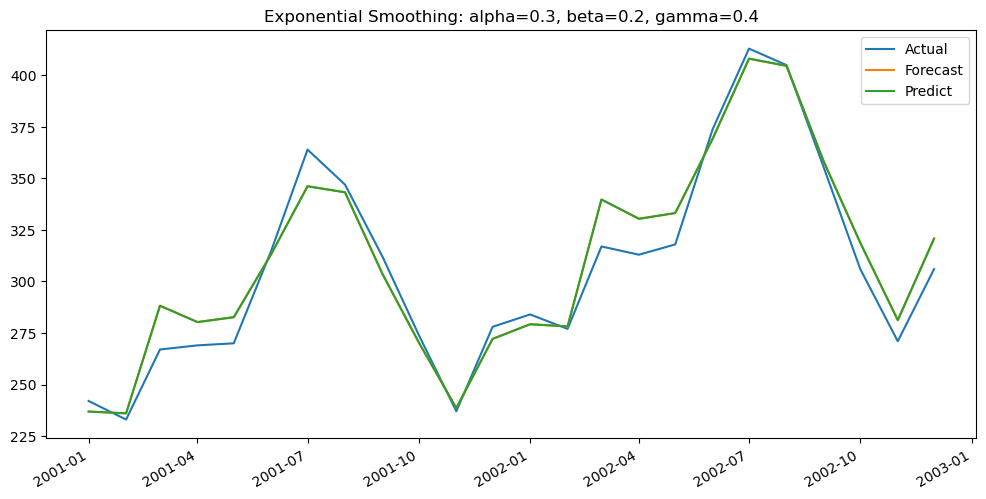


Parameters: alpha=0.3, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4907.442
Optimized:                         True   AIC                            335.973
Trend:                   Multiplicative   BIC                            372.399
Seasonal:                Multiplicative   AICC                           348.878
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

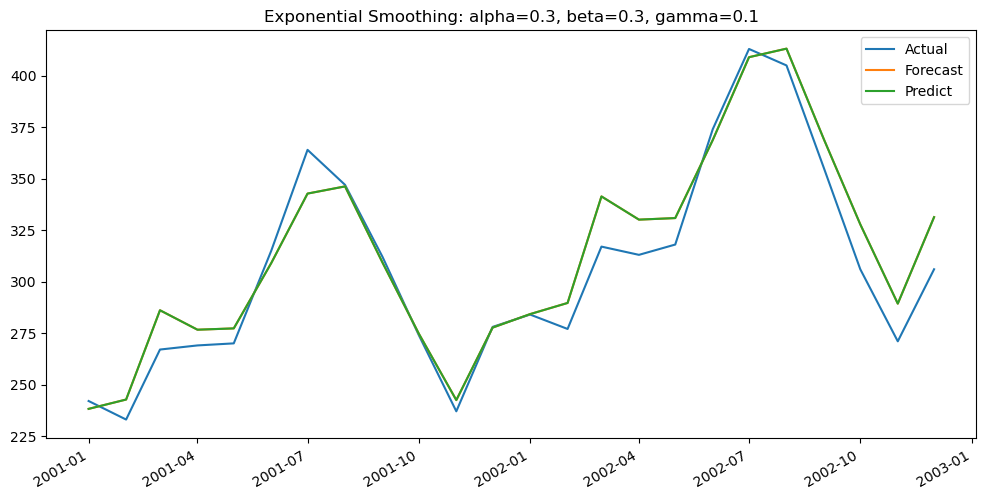


Parameters: alpha=0.3, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5350.652
Optimized:                         True   AIC                            342.198
Trend:                   Multiplicative   BIC                            378.625
Seasonal:                Multiplicative   AICC                           355.104
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:38
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

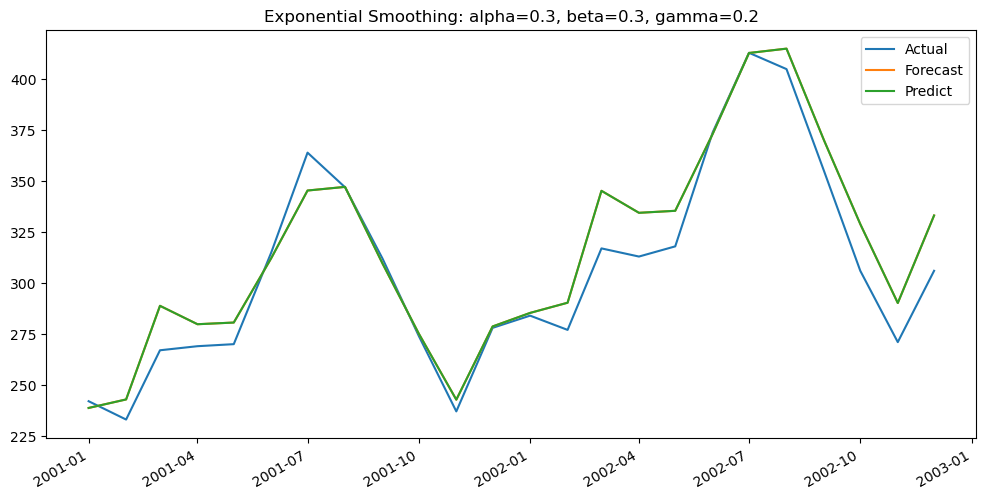


Parameters: alpha=0.3, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5695.286
Optimized:                         True   AIC                            346.692
Trend:                   Multiplicative   BIC                            383.119
Seasonal:                Multiplicative   AICC                           359.598
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

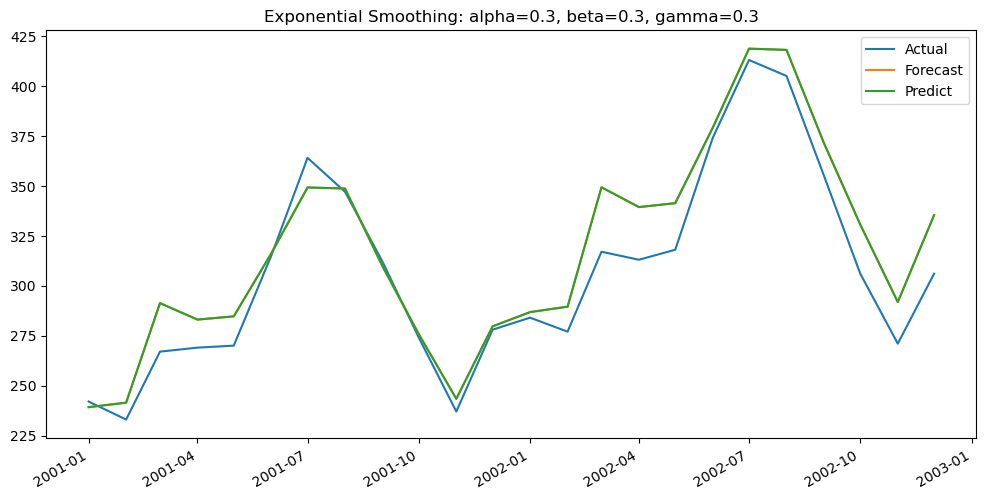


Parameters: alpha=0.3, beta=0.3, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5957.740
Optimized:                         True   AIC                            349.936
Trend:                   Multiplicative   BIC                            386.363
Seasonal:                Multiplicative   AICC                           362.842
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

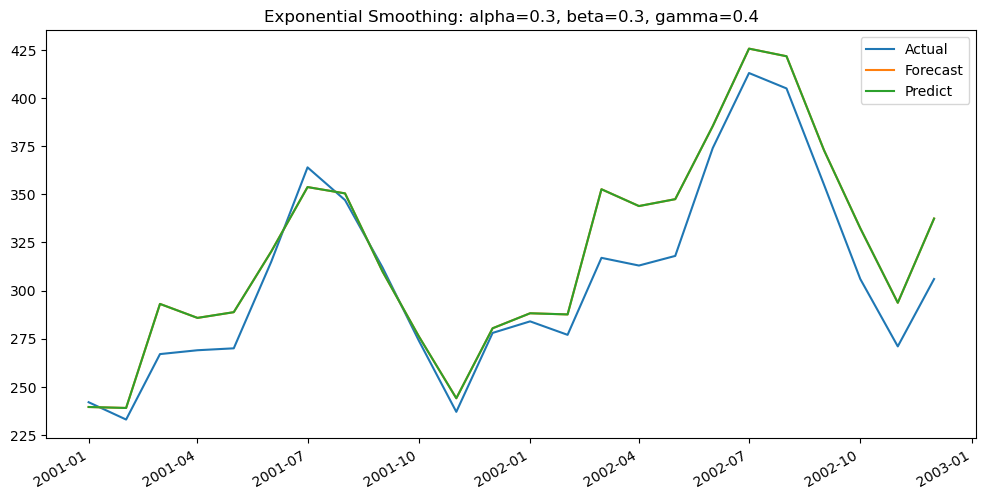


Parameters: alpha=0.3, beta=0.4, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5017.755
Optimized:                         True   AIC                            337.573
Trend:                   Multiplicative   BIC                            374.000
Seasonal:                Multiplicative   AICC                           350.479
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

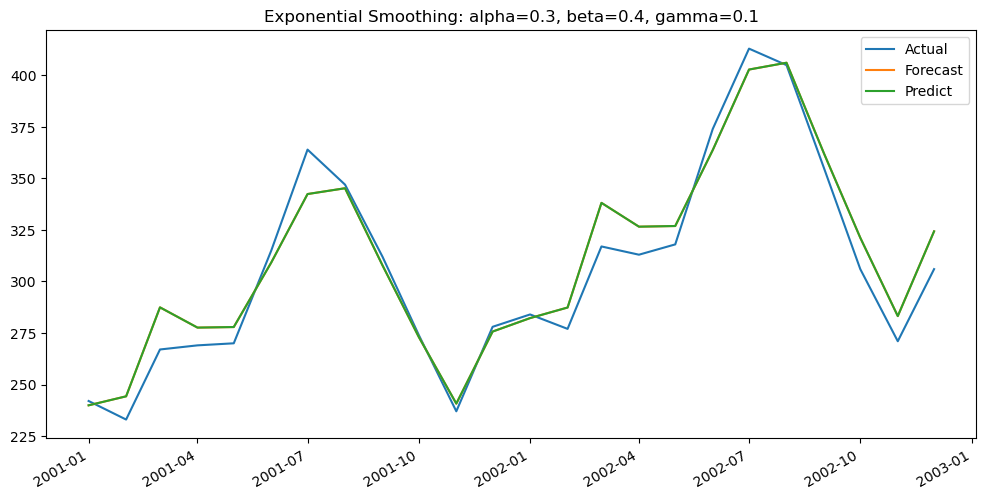


Parameters: alpha=0.3, beta=0.4, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5445.723
Optimized:                         True   AIC                            343.466
Trend:                   Multiplicative   BIC                            379.893
Seasonal:                Multiplicative   AICC                           356.372
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

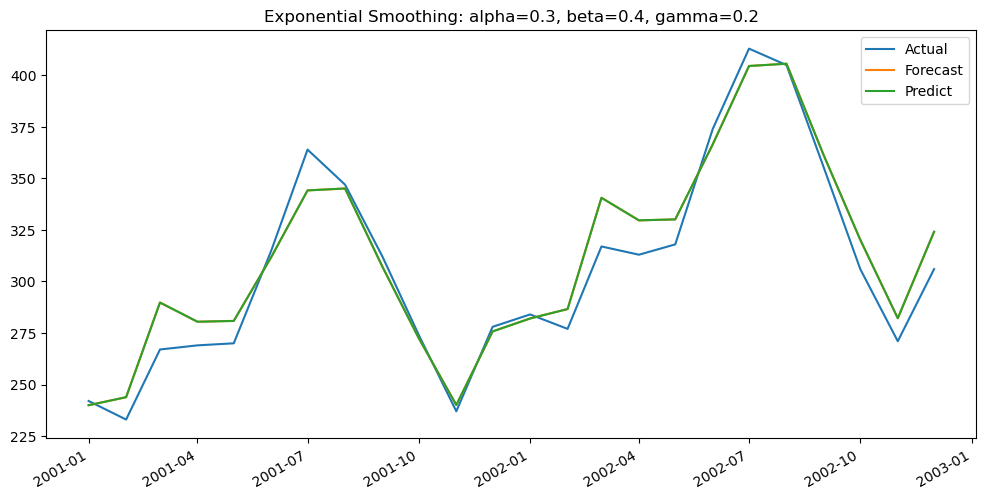


Parameters: alpha=0.3, beta=0.4, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5734.903
Optimized:                         True   AIC                            347.192
Trend:                   Multiplicative   BIC                            383.618
Seasonal:                Multiplicative   AICC                           360.097
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:46
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

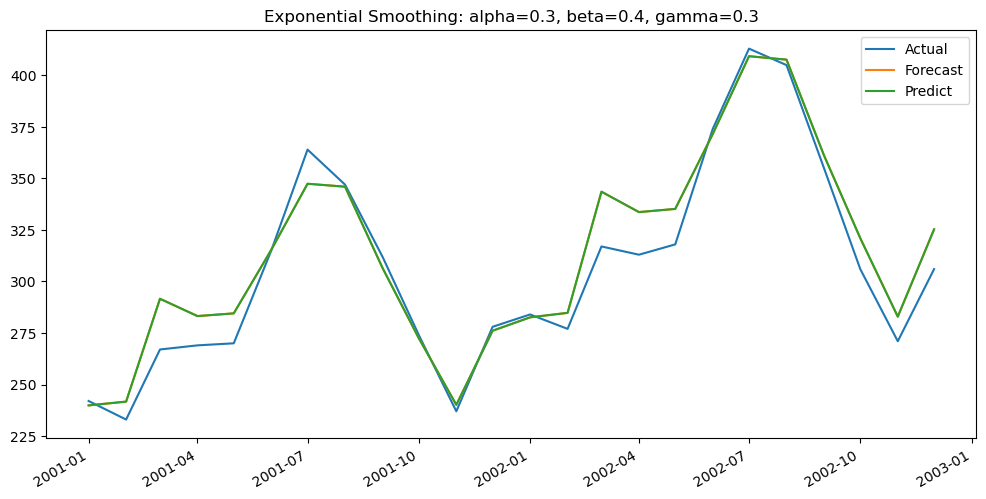


Parameters: alpha=0.3, beta=0.4, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5931.104
Optimized:                         True   AIC                            349.614
Trend:                   Multiplicative   BIC                            386.040
Seasonal:                Multiplicative   AICC                           362.519
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:48
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   

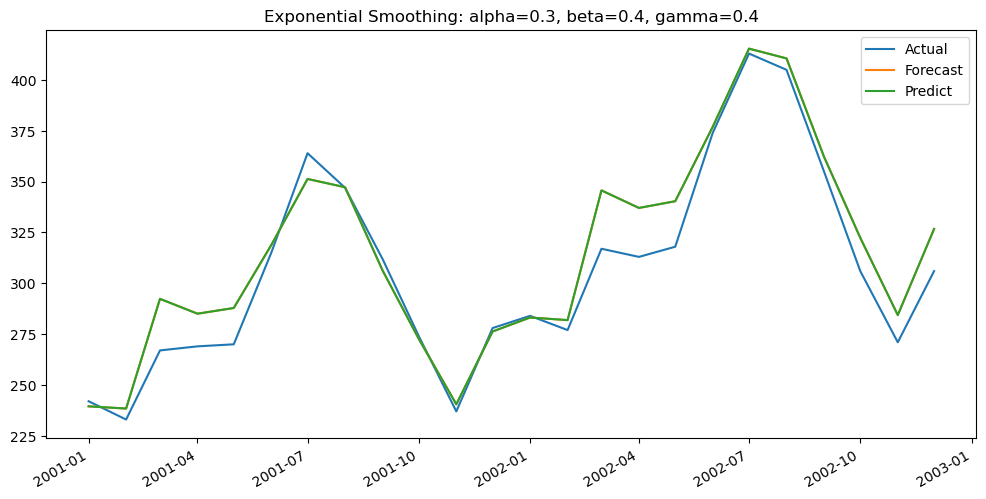


Parameters: alpha=0.4, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           3942.007
Optimized:                         True   AIC                            320.200
Trend:                   Multiplicative   BIC                            356.627
Seasonal:                Multiplicative   AICC                           333.106
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:50
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

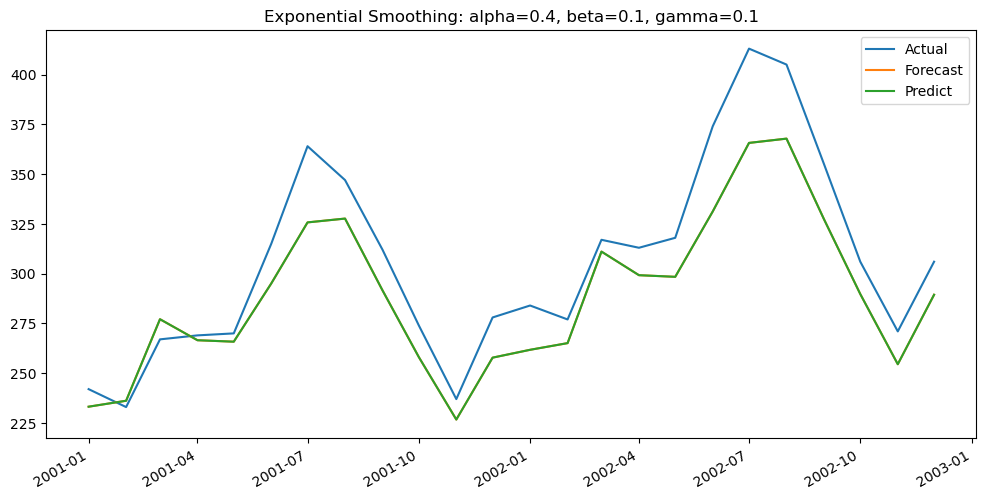


Parameters: alpha=0.4, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4315.221
Optimized:                         True   AIC                            326.713
Trend:                   Multiplicative   BIC                            363.140
Seasonal:                Multiplicative   AICC                           339.619
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

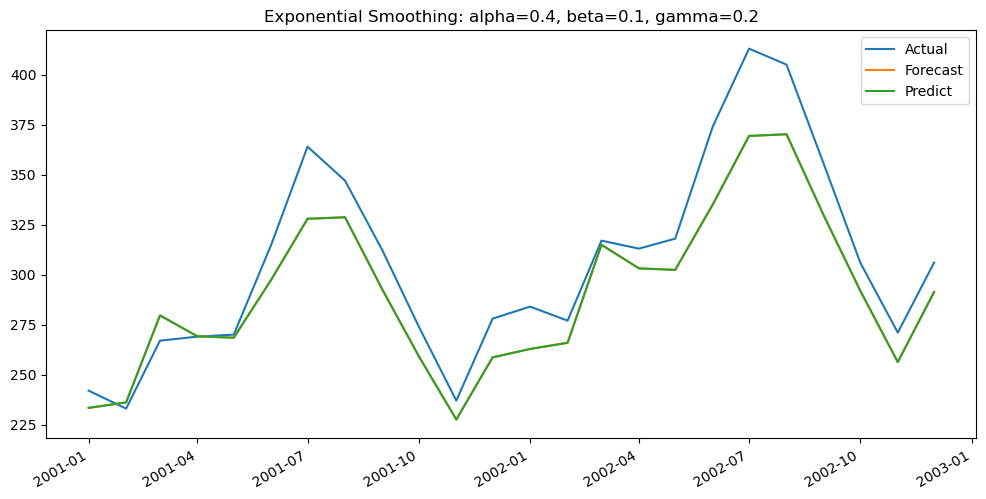


Parameters: alpha=0.4, beta=0.1, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4627.310
Optimized:                         True   AIC                            331.741
Trend:                   Multiplicative   BIC                            368.167
Seasonal:                Multiplicative   AICC                           344.646
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:53
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

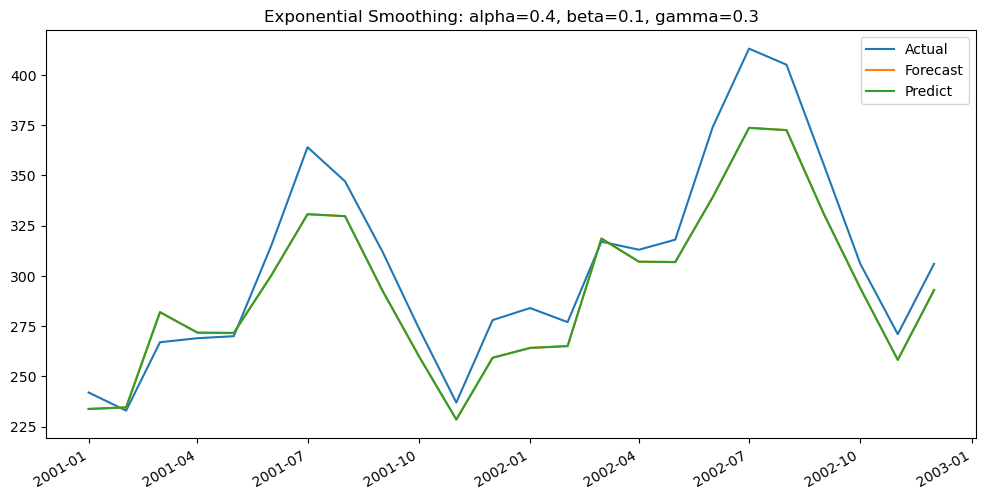


Parameters: alpha=0.4, beta=0.1, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4904.977
Optimized:                         True   AIC                            335.936
Trend:                   Multiplicative   BIC                            372.363
Seasonal:                Multiplicative   AICC                           348.842
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:55
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

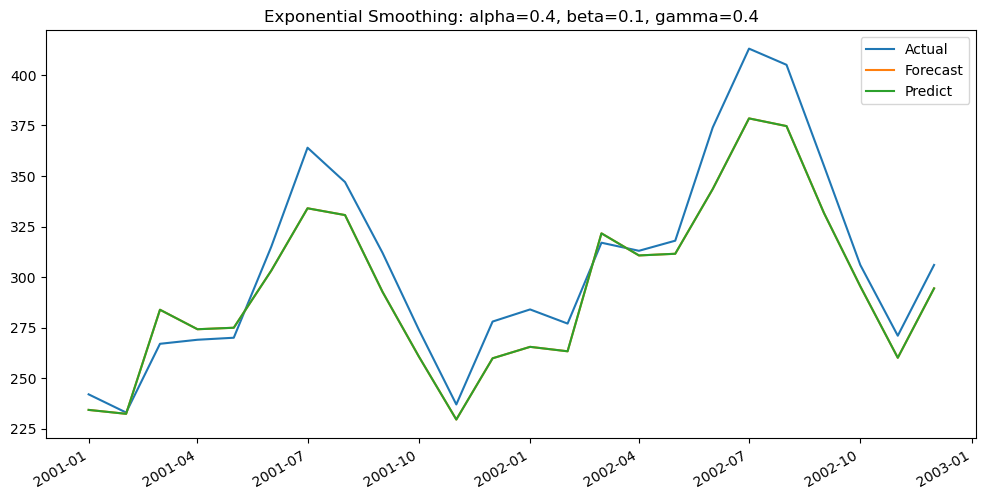


Parameters: alpha=0.4, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4229.129
Optimized:                         True   AIC                            325.262
Trend:                   Multiplicative   BIC                            361.689
Seasonal:                Multiplicative   AICC                           338.168
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

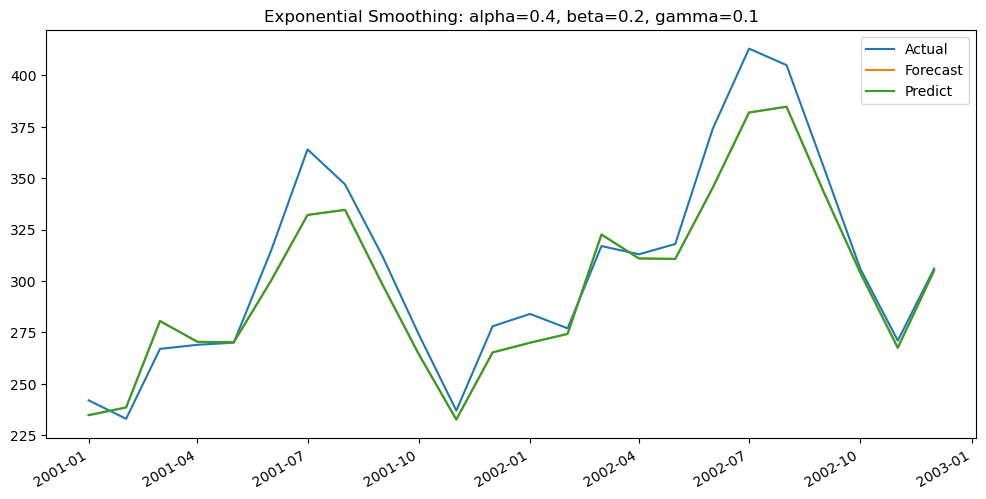


Parameters: alpha=0.4, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4618.745
Optimized:                         True   AIC                            331.607
Trend:                   Multiplicative   BIC                            368.034
Seasonal:                Multiplicative   AICC                           344.513
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:50:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

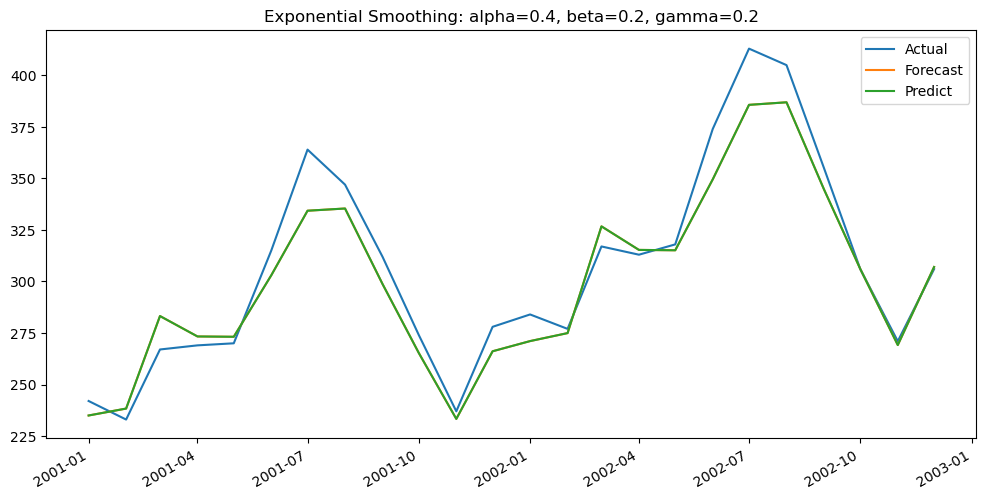


Parameters: alpha=0.4, beta=0.2, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4935.115
Optimized:                         True   AIC                            336.377
Trend:                   Multiplicative   BIC                            372.804
Seasonal:                Multiplicative   AICC                           349.283
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:01
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

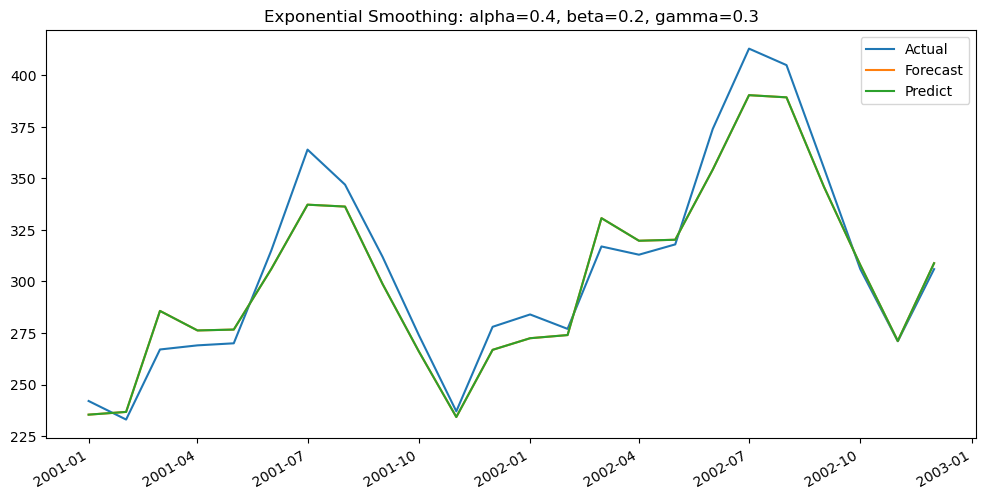


Parameters: alpha=0.4, beta=0.2, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5208.176
Optimized:                         True   AIC                            340.255
Trend:                   Multiplicative   BIC                            376.682
Seasonal:                Multiplicative   AICC                           353.161
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

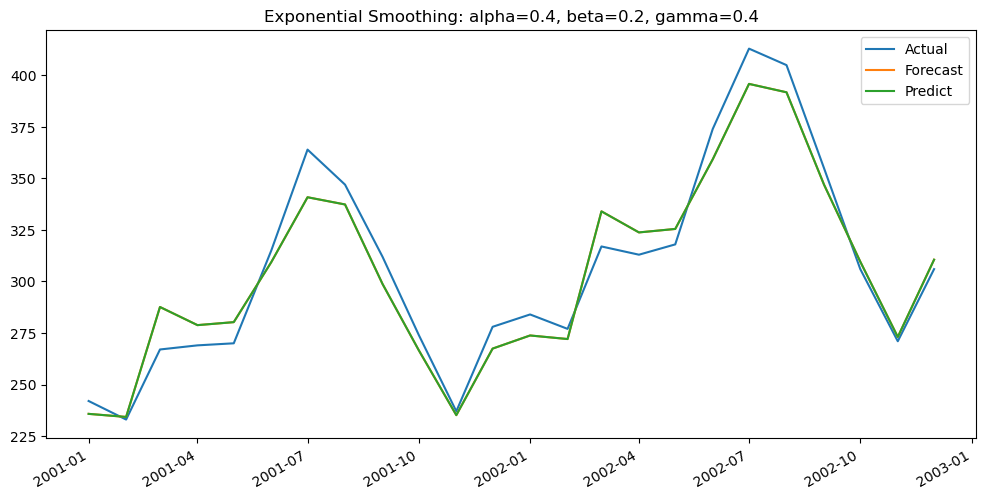


Parameters: alpha=0.4, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4412.201
Optimized:                         True   AIC                            328.313
Trend:                   Multiplicative   BIC                            364.740
Seasonal:                Multiplicative   AICC                           341.219
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

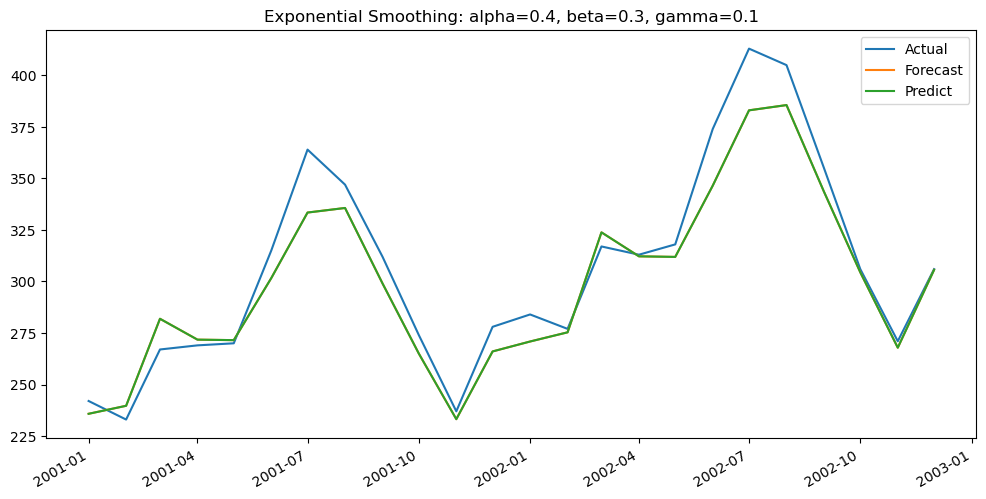


Parameters: alpha=0.4, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4800.550
Optimized:                         True   AIC                            334.387
Trend:                   Multiplicative   BIC                            370.814
Seasonal:                Multiplicative   AICC                           347.293
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

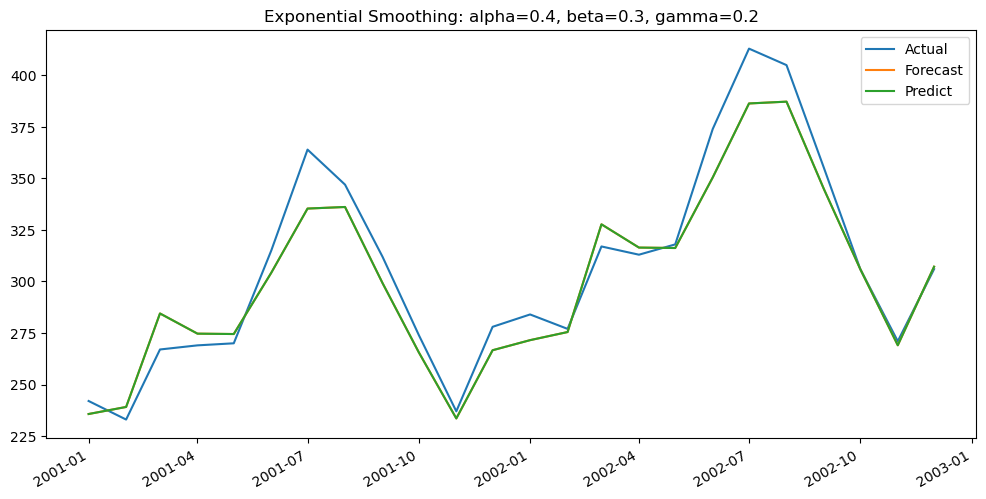


Parameters: alpha=0.4, beta=0.3, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5098.851
Optimized:                         True   AIC                            338.728
Trend:                   Multiplicative   BIC                            375.154
Seasonal:                Multiplicative   AICC                           351.633
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

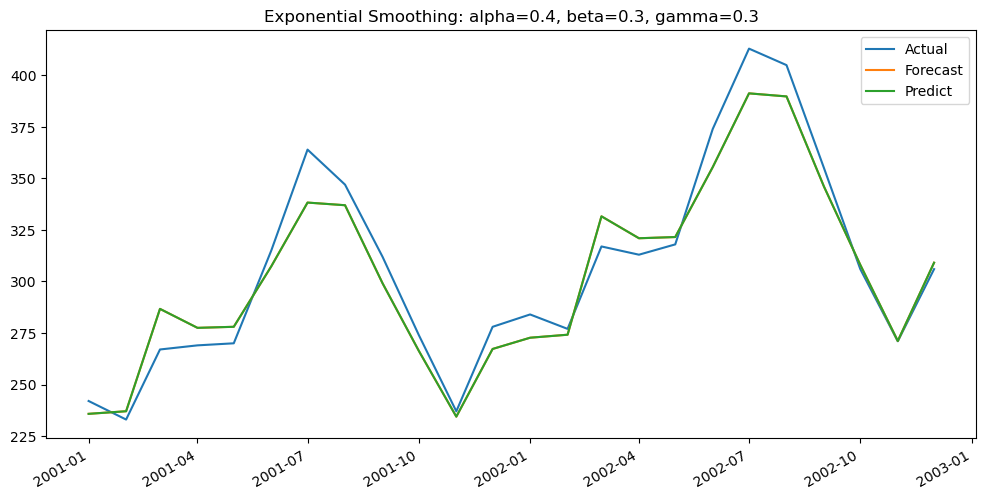


Parameters: alpha=0.4, beta=0.3, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5351.932
Optimized:                         True   AIC                            342.215
Trend:                   Multiplicative   BIC                            378.642
Seasonal:                Multiplicative   AICC                           355.121
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

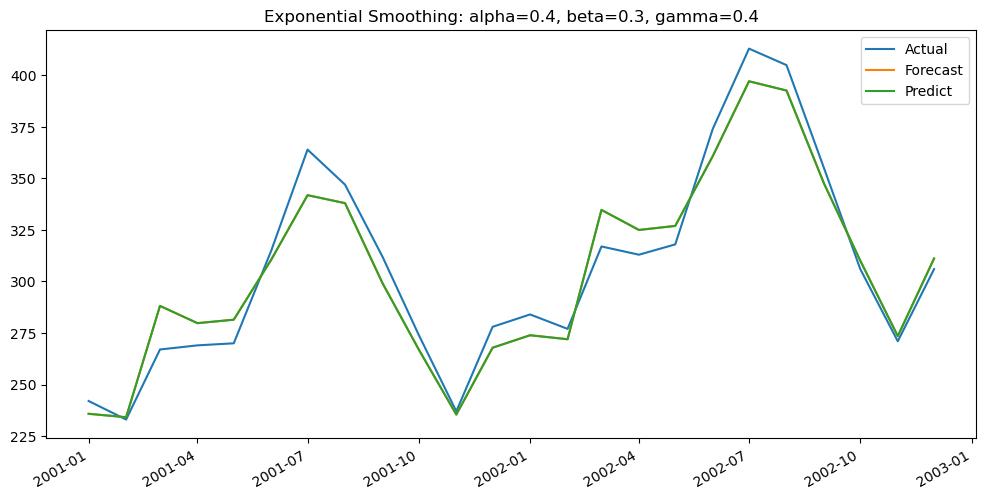


Parameters: alpha=0.4, beta=0.4, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4570.241
Optimized:                         True   AIC                            330.847
Trend:                   Multiplicative   BIC                            367.274
Seasonal:                Multiplicative   AICC                           343.753
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:14
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

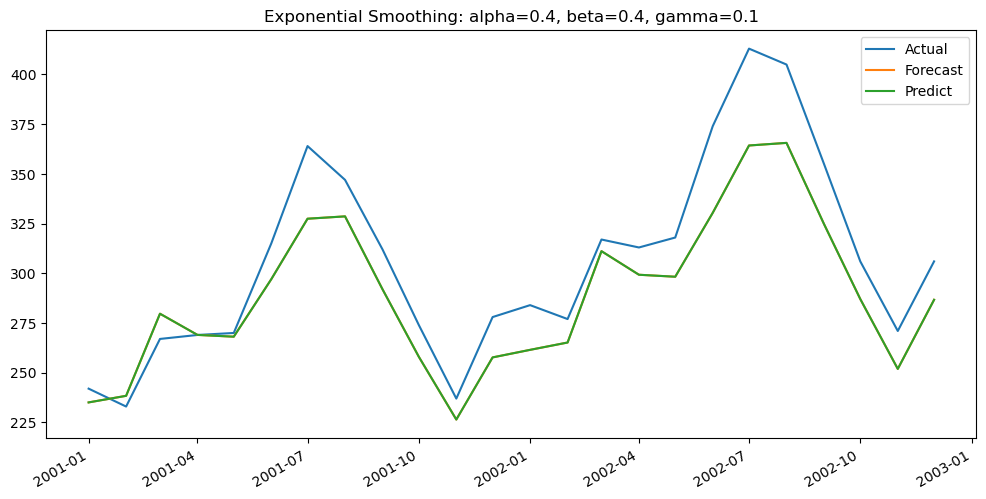


Parameters: alpha=0.4, beta=0.4, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4946.961
Optimized:                         True   AIC                            336.550
Trend:                   Multiplicative   BIC                            372.977
Seasonal:                Multiplicative   AICC                           349.456
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

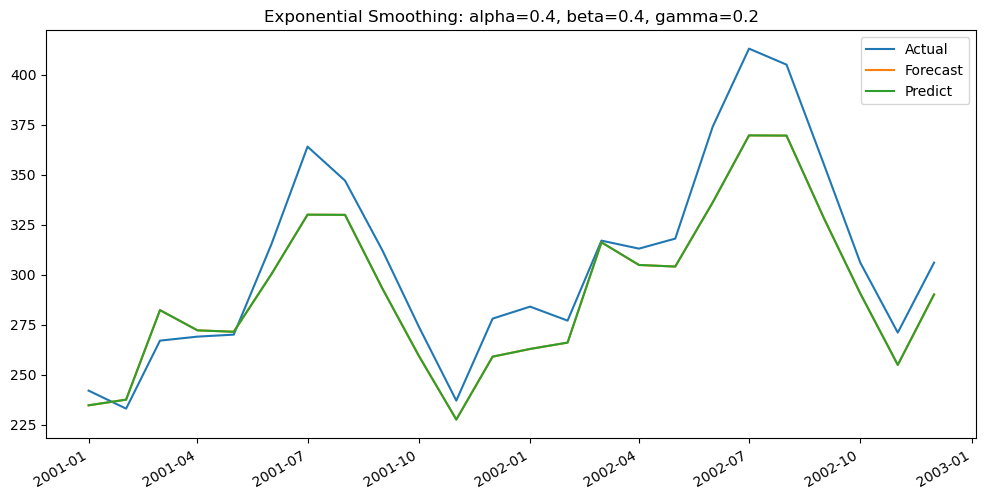


Parameters: alpha=0.4, beta=0.4, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5226.713
Optimized:                         True   AIC                            340.511
Trend:                   Multiplicative   BIC                            376.937
Seasonal:                Multiplicative   AICC                           353.416
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

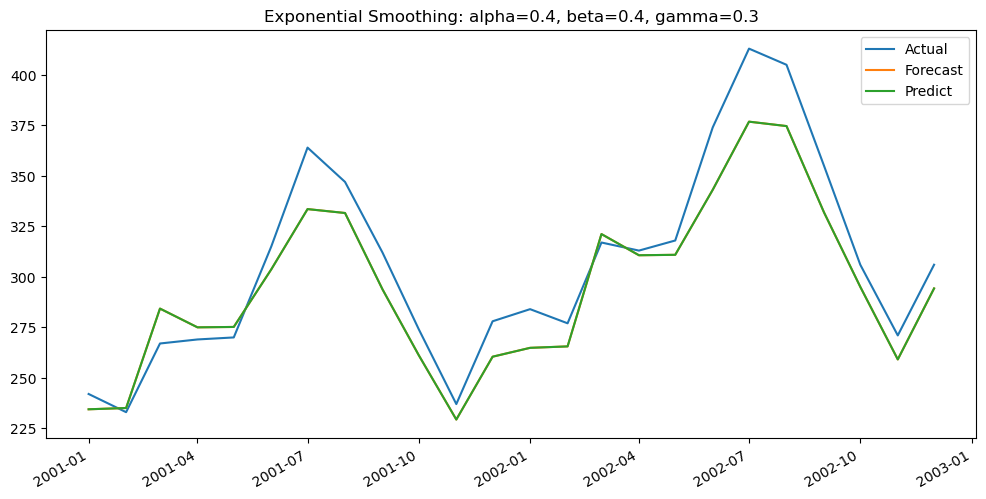


Parameters: alpha=0.4, beta=0.4, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5475.131
Optimized:                         True   AIC                            343.854
Trend:                   Multiplicative   BIC                            380.281
Seasonal:                Multiplicative   AICC                           356.760
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:51:19
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

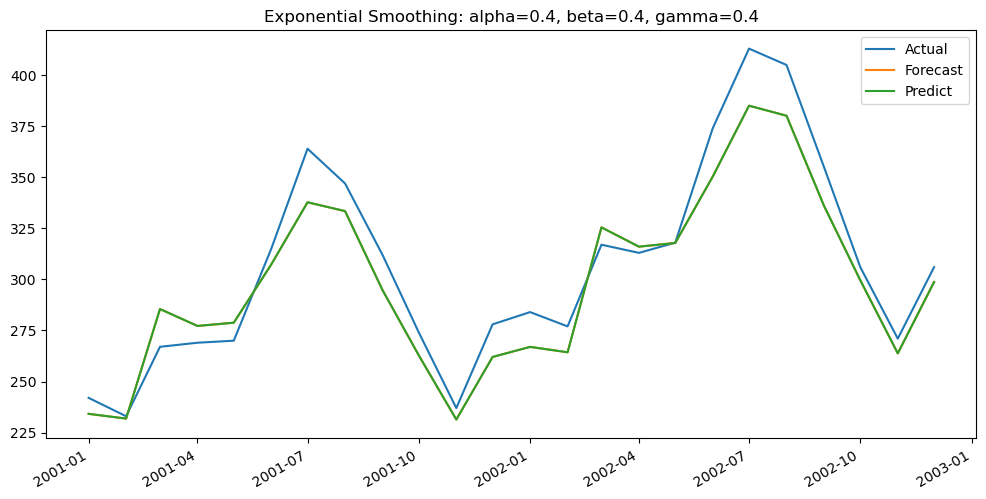

In [96]:
# Perform Exponential Smoothing with different parameter values
for alpha in smoothing_level_values:
    for beta in smoothing_trend_values:
        for gamma in smoothing_seasonal_values:
            model = ExponentialSmoothing(train['Passengers'], trend='mul', seasonal='mul', 
                                         seasonal_periods=12, 
                                         use_boxcox=False)
            result = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
            # Print model summary
            print(f"\nParameters: alpha={alpha}, beta={beta}, gamma={gamma}")
            print(result.summary())
            predict_1 = result.predict(start = test.index[0],end = test.index[-1])
            forecast = result.forecast(len(test.index))
            plt.figure(figsize=(12, 6))
            plt.plot(test['Passengers'], label='Actual')
            plt.plot(forecast, label='Forecast')
            predict_1.plot(label = 'Predict',legend =True)
            plt.title(f'Exponential Smoothing: alpha={alpha}, beta={beta}, gamma={gamma}')
            plt.legend()
            plt.show()

In [97]:
# Define the parameter values to try
smoothing_level_values = [0.1, 0.2, 0.3, 0.4]
smoothing_trend_values = [0.1, 0.2, 0.3, 0.4]
smoothing_seasonal_values = [0.1, 0.2, 0.3, 0.4]

# Initialize variables to store the best parameters and corresponding performance metric
best_params = None
best_mse = np.inf  # Initialize with a large value

# Perform Exponential Smoothing with different parameter values
for alpha in smoothing_level_values:
    for beta in smoothing_trend_values:
        for gamma in smoothing_seasonal_values:
            model = ExponentialSmoothing(train['Passengers'], trend='mul', seasonal='mul', 
                                         seasonal_periods=12, 
                                         use_boxcox=False)
            result = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

            # Make predictions on the test set
            forecast = result.forecast(len(test.index))

            # Evaluate the model using Mean Squared Error (you can use other metrics as well)
            mse = mean_squared_error(test['Passengers'], forecast)

            # Print model summary and MSE
            print(f"\nParameters: alpha={alpha}, beta={beta}, gamma={gamma}")
            print(result.summary())
            print(f'Mean Squared Error: {mse}')

            # Update best parameters if the current model performs better
            if mse < best_mse:
                best_params = (alpha, beta, gamma)
                best_mse = mse

# Print the best parameters
print("\nBest Parameters:")
print(f"alpha={best_params[0]}, beta={best_params[1]}, gamma={best_params[2]}")


Parameters: alpha=0.1, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5944.731
Optimized:                         True   AIC                            349.779
Trend:                   Multiplicative   BIC                            386.205
Seasonal:                Multiplicative   AICC                           362.684
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5970.646
Optimized:                         True   AIC                            350.092
Trend:                   Multiplicative   BIC                            386.519
Seasonal:                Multiplicative   AICC                           362.998
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend          


Parameters: alpha=0.1, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6326.488
Optimized:                         True   AIC                            354.260
Trend:                   Multiplicative   BIC                            390.687
Seasonal:                Multiplicative   AICC                           367.166
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   


Parameters: alpha=0.1, beta=0.4, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7295.533
Optimized:                         True   AIC                            364.521
Trend:                   Multiplicative   BIC                            400.948
Seasonal:                Multiplicative   AICC                           377.427
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha   


Parameters: alpha=0.2, beta=0.1, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5256.114
Optimized:                         True   AIC                            340.915
Trend:                   Multiplicative   BIC                            377.341
Seasonal:                Multiplicative   AICC                           353.820
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   


Parameters: alpha=0.2, beta=0.2, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5948.083
Optimized:                         True   AIC                            349.819
Trend:                   Multiplicative   BIC                            386.246
Seasonal:                Multiplicative   AICC                           362.725
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   


Parameters: alpha=0.2, beta=0.3, gamma=0.2
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           6507.500
Optimized:                         True   AIC                            356.291
Trend:                   Multiplicative   BIC                            392.718
Seasonal:                Multiplicative   AICC                           369.197
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   


Parameters: alpha=0.2, beta=0.4, gamma=0.3
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           7119.095
Optimized:                         True   AIC                            362.759
Trend:                   Multiplicative   BIC                            399.185
Seasonal:                Multiplicative   AICC                           375.664
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha   


Parameters: alpha=0.3, beta=0.1, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5338.802
Optimized:                         True   AIC                            342.039
Trend:                   Multiplicative   BIC                            378.465
Seasonal:                Multiplicative   AICC                           354.944
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   


Parameters: alpha=0.3, beta=0.2, gamma=0.4
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5806.746
Optimized:                         True   AIC                            348.088
Trend:                   Multiplicative   BIC                            384.515
Seasonal:                Multiplicative   AICC                           360.994
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   


Parameters: alpha=0.3, beta=0.4, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           5017.755
Optimized:                         True   AIC                            337.573
Trend:                   Multiplicative   BIC                            374.000
Seasonal:                Multiplicative   AICC                           350.479
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:13
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3000000                alpha   


Parameters: alpha=0.4, beta=0.1, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           3942.007
Optimized:                         True   AIC                            320.200
Trend:                   Multiplicative   BIC                            356.627
Seasonal:                Multiplicative   AICC                           333.106
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:14
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   


Parameters: alpha=0.4, beta=0.2, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4229.129
Optimized:                         True   AIC                            325.262
Trend:                   Multiplicative   BIC                            361.689
Seasonal:                Multiplicative   AICC                           338.168
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:15
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   


Parameters: alpha=0.4, beta=0.3, gamma=0.1
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4412.201
Optimized:                         True   AIC                            328.313
Trend:                   Multiplicative   BIC                            364.740
Seasonal:                Multiplicative   AICC                           341.219
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha   

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                           4570.241
Optimized:                         True   AIC                            330.847
Trend:                   Multiplicative   BIC                            367.274
Seasonal:                Multiplicative   AICC                           343.753
Seasonal Periods:                    12   Date:                 Wed, 22 Nov 2023
Box-Cox:                          False   Time:                         05:57:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4000000                alpha                False
smoothing_trend          

# Here the bes parameters smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.4

# Build a model with the above parameters

In [98]:
model_test = ExponentialSmoothing(train['Passengers'],seasonal='mul',trend = 'mul',
                                seasonal_periods=12).fit(smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.4)
model_predict = model_test.predict(test.index[0],test.index[-1])

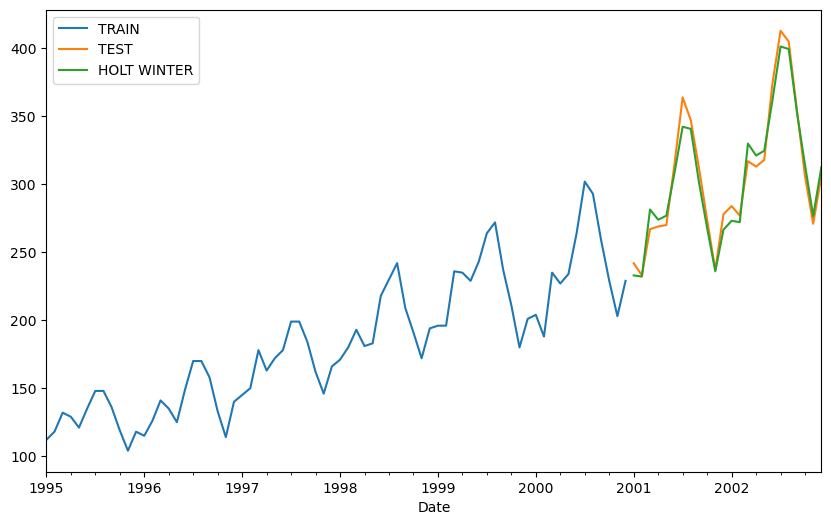

In [99]:
# Plot the train, test and predicted values
train['Passengers'].plot(legend = True,label ='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
model_predict.plot(legend = True,label = 'HOLT WINTER');

In [101]:
# Calculate RMSE
rmse_model = rmse(test['Passengers'],model_predict)
rmse_model

9.2995630994932

In [102]:
test['Passengers'].mean()

306.125

In [103]:
9.3*100/306.2

3.0372305682560423

# So far the Holt winter method with multiplicative seasonality and trend, smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.4 is giving the best result and RMSE of the model is also very less when compared to other models

In [104]:
rmse_df = pd.DataFrame({'Model':['Simple exp',
                                'Double Exp',
                                'Tri exp Add_Add',
                                'Tri exp Add_Mul',
                                'Tri exp Mul_Add',
                                'Tri exp Mul_Mul',
                                'Tri exp Mul_Mul_hyp'],
                       'RMSE':[rmse_ses,rmse_holt,rmse_hw_add,rmse_hw_add_mul,
                               rmse_hw_mul_add,rmse_hw_mul_mul,rmse_model]})

In [105]:
rmse_df.sort_values(by='RMSE',ascending=True)

Model       RMSE
6  Tri exp Mul_Mul_hyp   9.299563
5      Tri exp Mul_Mul  23.058781
3      Tri exp Add_Mul  34.989262
4      Tri exp Mul_Add  41.230940
2      Tri exp Add_Add  47.568387
1           Double Exp  59.951257
0           Simple exp  91.113254

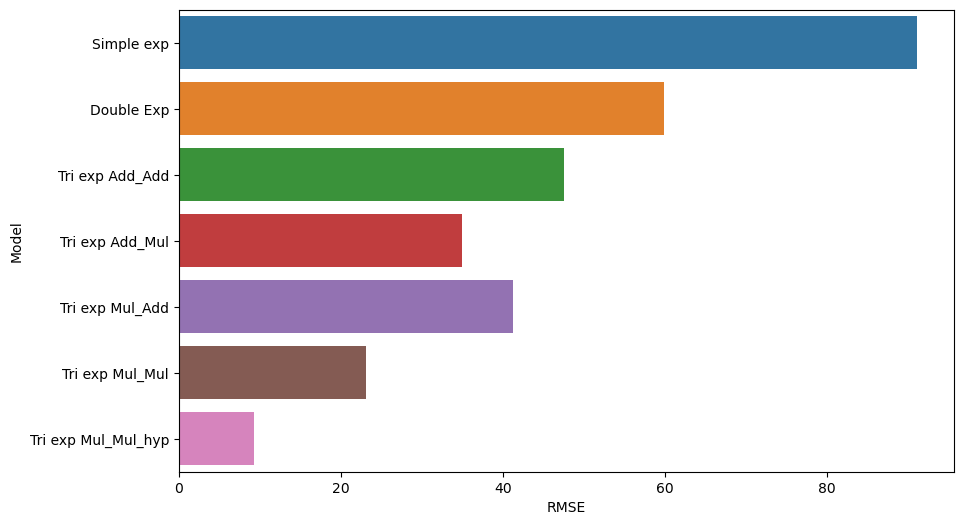

In [106]:
sns.barplot(data = rmse_df , y = 'Model', x = 'RMSE' );

In [107]:
# import adfuller
from statsmodels.tsa.stattools import adfuller

In [112]:
print(df.dtypes)

Passengers     int64
month         object
year          object
Apr            uint8
Aug            uint8
Dec            uint8
Feb            uint8
Jan            uint8
Jul            uint8
Jun            uint8
Mar            uint8
May            uint8
Nov            uint8
Oct            uint8
Sep            uint8
dtype: object


In [113]:
print(df['Passengers'].isnull().sum())

0


In [125]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

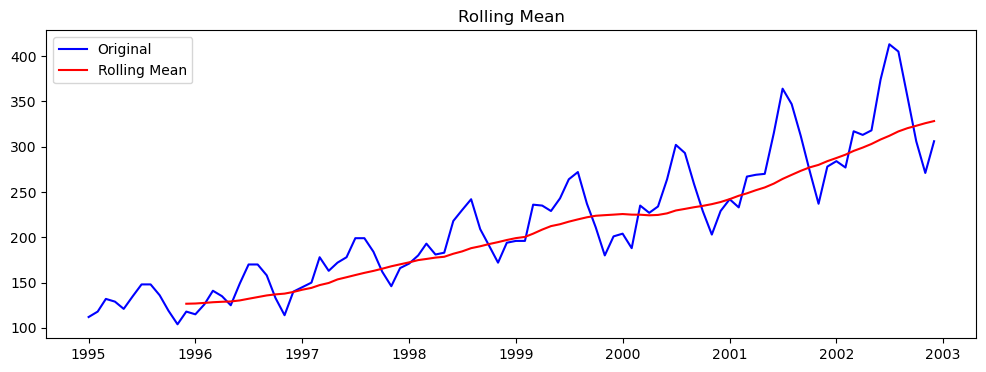

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [127]:
plt.figure(figsize=(12,4))
Passengers= pd.DataFrame()
Passengers['Passengers'] = df[['Passengers']]
test_stationarity(Passengers)

# From the above the mean is not stationery as it is incresing and p value is also very high. We can not rejest the null hypothesis and the data is not stationery

# Transformation of the data

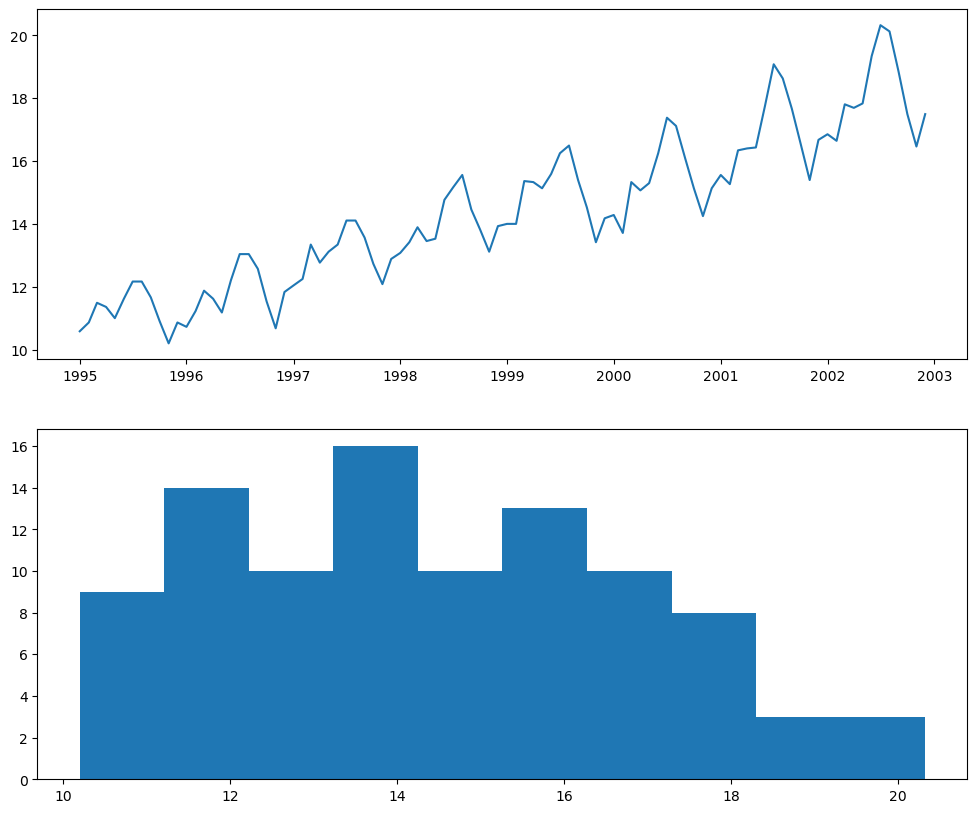

In [128]:
square_root= pd.DataFrame()
square_root = df[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

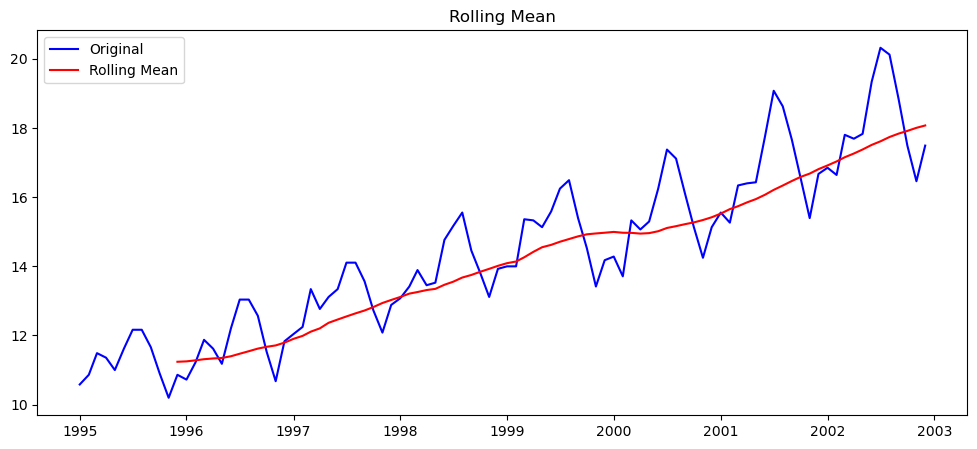

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [129]:
plt.figure(figsize=(12,5))
test_stationarity(square_root)

# Here also the p value is greater than 0.05, and the data is not stationery

# Log Transform of the data

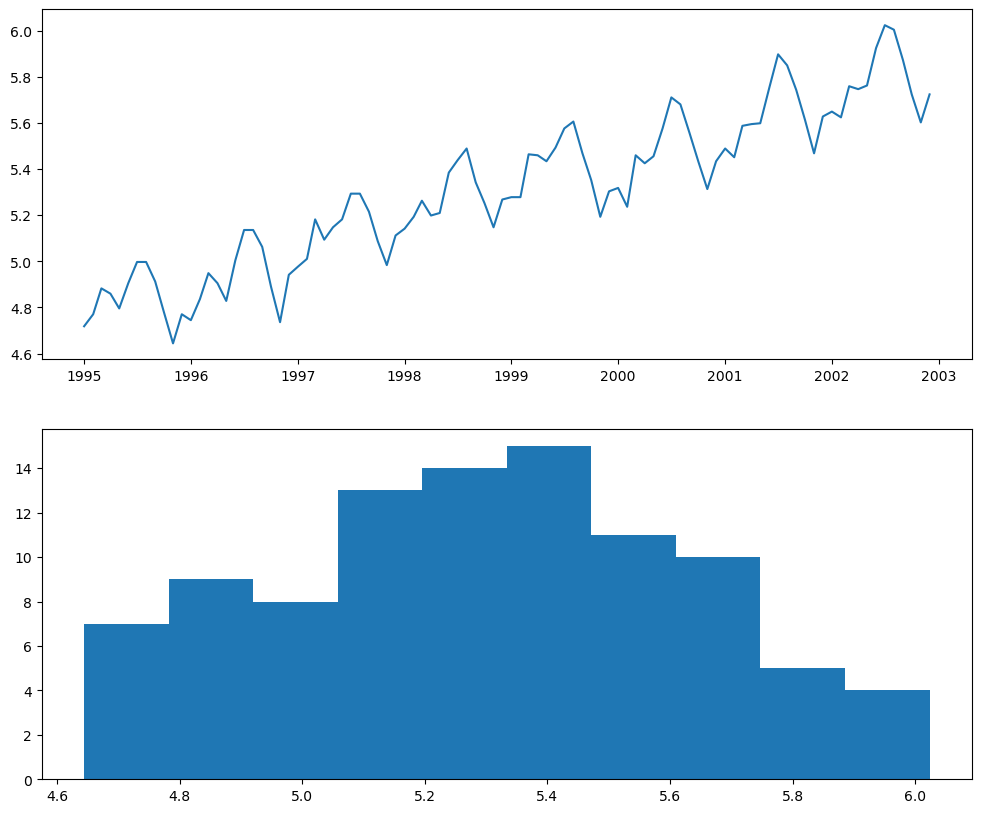

In [130]:
log = pd.DataFrame()
log = df[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig = plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

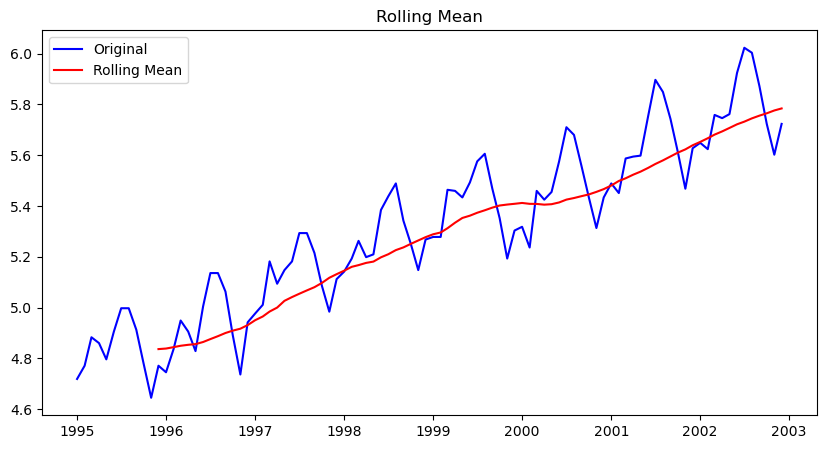

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [131]:
plt.figure(figsize=(10,5))
test_stationarity(log)

# Here also the p value is greater than the significance level and we fail to reject the null hypothesis and the data is not stationery

# Convert the non stationery data to stationery data

# Box cox Transformation

Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

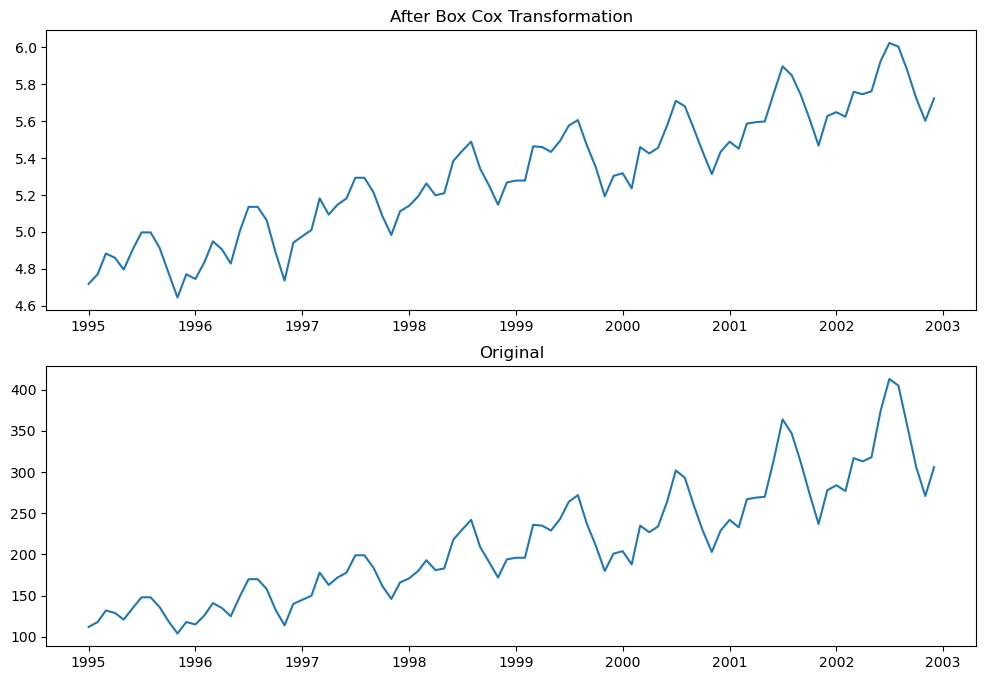

In [136]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df['Passengers'], lmbda=0), df.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(12,8),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df['Passengers'], label='original')
axis[1].set_title('Original')
plt.show()

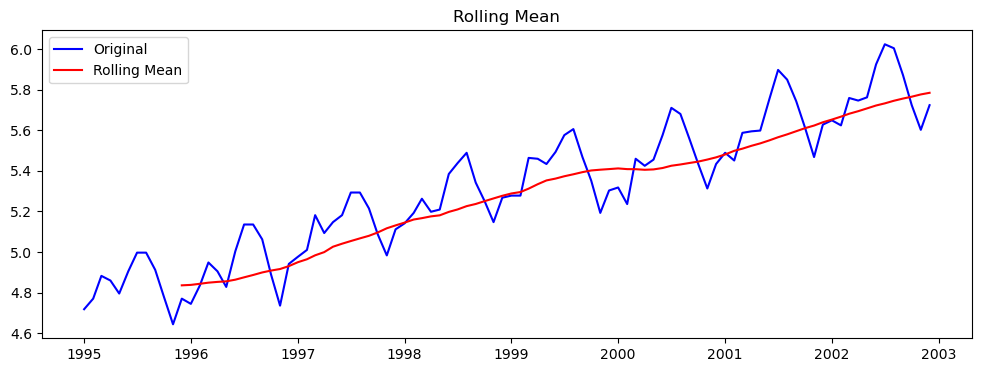

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [137]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox)

# P value is greater than 0.05 and failed to reject the null hypotheis and the data is not stationery

# Differencing the box cox tranformation

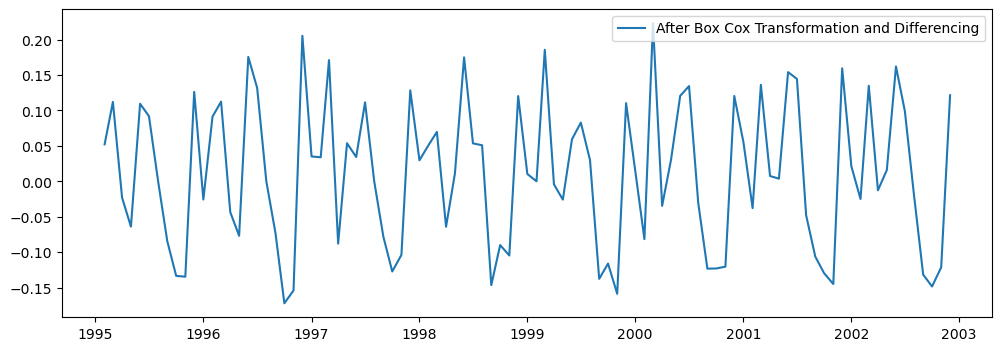

In [144]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

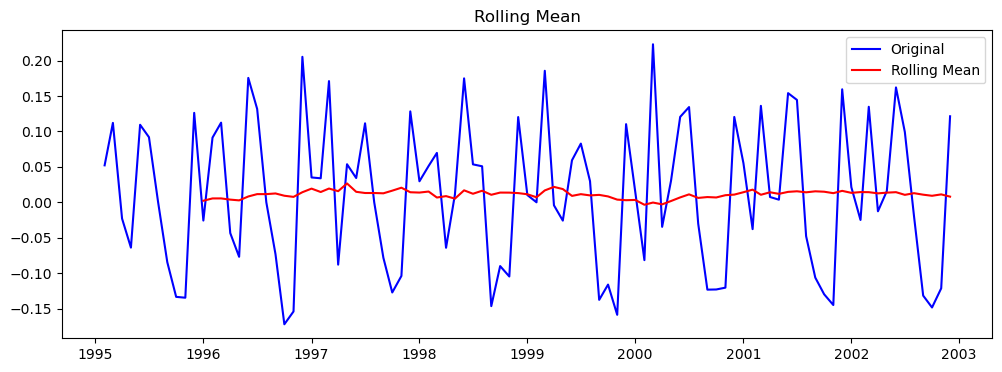

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [145]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

# After Box cox differencing to one shift, the p vaue is still greater than 0.05. We will try to shift the values to 2 and let us see

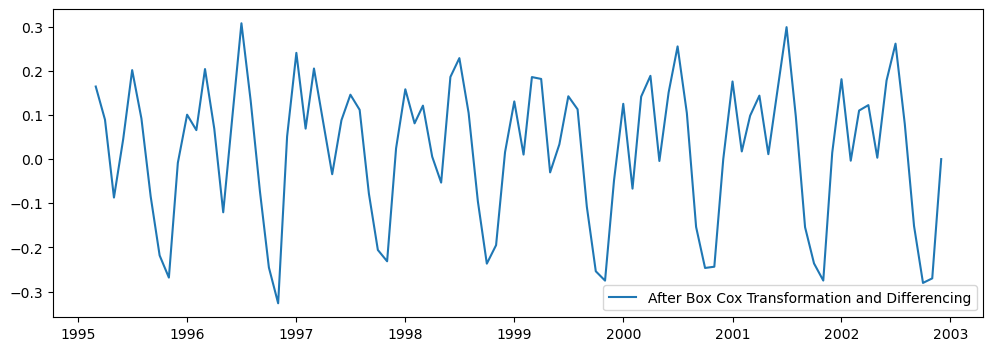

In [146]:
data_boxcox_diff = data_boxcox - data_boxcox.shift(2)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

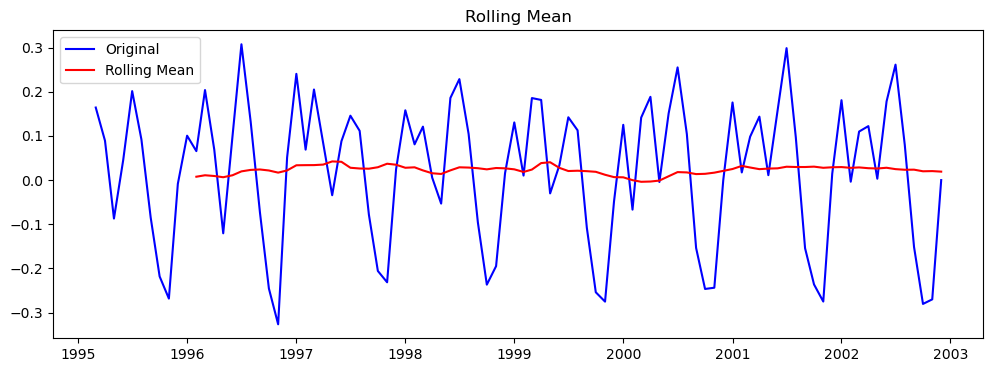

Results of Dickey Fuller Test:
Test Statistic                 -2.787629
p-value                         0.060063
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [147]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

# After 2 differences the mean is almost stationery and we will use this data for further processing

In [148]:
data_boxcox_diff.head()

Passengers
Date                  
1995-03-01    0.164303
1995-04-01    0.089128
1995-05-01   -0.087011
1995-06-01    0.045462
1995-07-01    0.201422

In [149]:
data_boxcox_diff.shape

(94, 1)

In [150]:
# Split the data to train and test data
train = data_boxcox_diff.iloc[:70]
test = data_boxcox_diff.iloc[70:]

In [151]:
train.shape, test.shape

((70, 1), (24, 1))

In [152]:
train.head()

Passengers
Date                  
1995-03-01    0.164303
1995-04-01    0.089128
1995-05-01   -0.087011
1995-06-01    0.045462
1995-07-01    0.201422

In [153]:
train.tail()

Passengers
Date                  
2000-08-01    0.104224
2000-09-01   -0.153599
2000-10-01   -0.246451
2000-11-01   -0.243622
2000-12-01    0.000000

In [154]:
test.head()

Passengers
Date                  
2001-01-01    0.175732
2001-02-01    0.017316
2001-03-01    0.098311
2001-04-01    0.143673
2001-05-01    0.011173

In [155]:
test.tail()

Passengers
Date                  
2002-08-01    0.079631
2002-09-01   -0.151330
2002-10-01   -0.280302
2002-11-01   -0.269999
2002-12-01    0.000000

# ARIMA model Hyper parameter tuning

In [156]:
# Arima model parameter tuning using auto_arima
from pmdarima import auto_arima

In [157]:
# Implement auto_arima to find the best parameters for value 0 to 3 for p and q
auto_arima_no_season = auto_arima(train['Passengers'],start_p=0,start_q=0,d = 1,max_p=3,max_q=3,
                                  seasonal=False,stepwise=False,trace=True)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.913, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-54.870, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69.165, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67.481, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 16.614

In [167]:
# Fit the model with the identified best parameters
arima_210 = ARIMA(train['Passengers'],order=(2,1,0))
result_210 = arima_210.fit()
forecast_210 = result_210.predict(start = len(train),end = len(train)+len(test)-1).rename('ARIMA (2,1,0) PREDICTIONS')

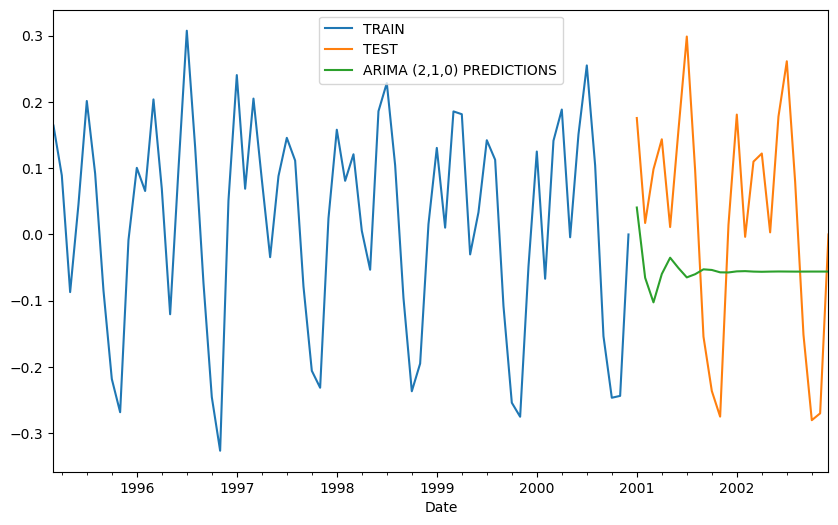

In [168]:
# Plot the train, test , forecast data
train['Passengers'].plot(legend = True , label = 'TRAIN')
test['Passengers'].plot(legend = True,label='TEST')
forecast_210.plot(legend = True);

In [169]:
rmse_210 = rmse(test['Passengers'],forecast_210)

In [170]:
rmse_210

0.1836130171700946

# The model is not able to capture neither trend nor seasonality and on the other side the RMSE is less because of differencing of the by 2

In [171]:
test['Passengers'].mean()

0.024115664176502277

In [172]:
0.18*100/0.025

720.0

# This means the model is not even giving 1% correct predictions 

In [174]:
# Try with different values of p and q from 1 to 3 and seasonal is true and m = 12
auto_arima_model = auto_arima(train['Passengers'],start_p=1,start_q=1,max_p=3,max_q=3,d = 1,max_d= 3 ,seasonal=True,trace=True,
                              stepwise=False,start_P = 0 ,max_P= 3 ,D = 1 ,max_D = 3 , m = 12,start_Q = 0, max_Q =3)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-128.530, Time=0.51 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-143.728, Time=0.92 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-141.748, Time=1.92 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=5.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-140.978, Time=0.37 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-141.756, Time=1.41 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-139.733, Time=2.09 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=8.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-139.975, Time=2.00 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.41 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=3.54 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=8.32 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-139.757, Time=1.19 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=-138.385, Time=11.29 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=11.76 sec
 ARIMA(0,1,1)(0,1,0)[12

In [175]:
model_sarima = SARIMAX(train['Passengers'],order = (0,1,3),seasonal_order=(1,1,0,12))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.predict(start = len(train),end = len(train)+len(test)-1).rename('SARIMA Forecast')
forecast_sarima

2001-01-01    0.135924
2001-02-01   -0.034427
2001-03-01    0.162761
2001-04-01    0.182591
2001-05-01   -0.020160
2001-06-01    0.086462
2001-07-01    0.193033
2001-08-01    0.106559
2001-09-01   -0.131530
2001-10-01   -0.252609
2001-11-01   -0.262508
2001-12-01   -0.027944
2002-01-01    0.128032
2002-02-01   -0.053819
2002-03-01    0.149279
2002-04-01    0.183547
2002-05-01   -0.013910
2002-06-01    0.118520
2002-07-01    0.223784
2002-08-01    0.103137
2002-09-01   -0.145422
2002-10-01   -0.251525
2002-11-01   -0.254671
2002-12-01   -0.015301
Freq: MS, Name: SARIMA Forecast, dtype: float64

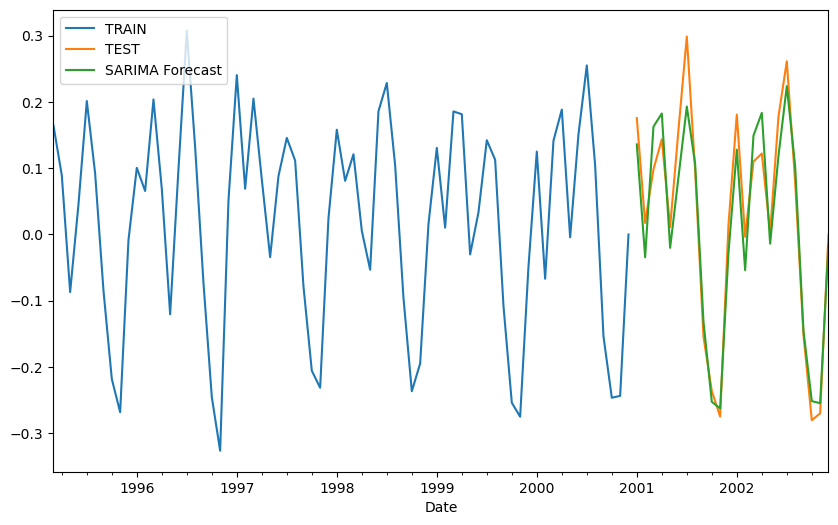

In [176]:
# Plot the train ,test and forecast values
train['Passengers'].plot(legend = True,label='TRAIN')
test['Passengers'].plot(legend = True,label = 'TEST')
forecast_sarima.plot(legend = True);

In [178]:
rmse_sarima = rmse(test['Passengers'],forecast_sarima)
rmse_sarima

0.04461935613753776

# The SARIMA MODEL with hyper parameter tuning is able to perform better and RMSE of the model is also seems to be good

# Forecast by Base Models

In [181]:
df.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep  
Date                            
1995-01-01    0    0    0    0  
1995-02-01    0    0    0    0  
1995-03-01    0    0    0    0  
1995-04-01    0    0    0    0  
1995-05-01    1    0    0    0

In [184]:
df.reset_index(inplace=True)
df['t'] = np.arange(1,len(df)+1)
df['t_squared'] = np.square(df.t)
df['log_Passengers'] = np.log(df['Passengers'])
df.head()

level_0  index       Date  Passengers month  year  Apr  Aug  Dec  Feb  ...  \
0        0      0 1995-01-01         112   Jan  1995    0    0    0    0  ...   
1        1      1 1995-02-01         118   Feb  1995    0    0    0    1  ...   
2        2      2 1995-03-01         132   Mar  1995    0    0    0    0  ...   
3        3      3 1995-04-01         129   Apr  1995    1    0    0    0  ...   
4        4      4 1995-05-01         121   May  1995    0    0    0    0  ...   

   Jul  Jun  Mar  May  Nov  Oct  Sep  t  t_squared  log_Passengers  
0    0    0    0    0    0    0    0  1          1        4.718499  
1    0    0    0    0    0    0    0  2          4        4.770685  
2    0    0    1    0    0    0    0  3          9        4.882802  
3    0    0    0    0    0    0    0  4         16        4.859812  
4    0    0    0    1    0    0    0  5         25        4.795791  

[5 rows x 21 columns]

In [186]:
df.drop(['level_0','index'],axis = 1,inplace = True)

In [187]:
df.head()

Date  Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
0 1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1 1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
2 1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
3 1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
4 1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

   May  Nov  Oct  Sep  t  t_squared  log_Passengers  
0    0    0    0    0  1          1        4.718499  
1    0    0    0    0  2          4        4.770685  
2    0    0    0    0  3          9        4.882802  
3    0    0    0    0  4         16        4.859812  
4    1    0    0    0  5         25        4.795791

In [188]:
df.set_index('Date',inplace = True)

In [189]:
df.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep  t  t_squared  log_Passengers  
Date                                                          
1995-01-01    0    0    0    0  1          1        4.718499  
1995-02-01    0    0    0    0  2          4        4.770685  
1995-03-01    0    0    0    0  3          9        4.882802  
1995-04-01    0    0    0    0  4         16        4.859812  
1995-05-01    1    0    0    0  5         25        4.795791

In [190]:
len(df)

96

In [191]:
train = df.iloc[:72]
test = df.iloc[72:]

In [192]:
train.shape, test.shape

((72, 18), (24, 18))

In [193]:
train.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
1995-01-01         112   Jan  1995    0    0    0    0    1    0    0    0   
1995-02-01         118   Feb  1995    0    0    0    1    0    0    0    0   
1995-03-01         132   Mar  1995    0    0    0    0    0    0    0    1   
1995-04-01         129   Apr  1995    1    0    0    0    0    0    0    0   
1995-05-01         121   May  1995    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep  t  t_squared  log_Passengers  
Date                                                          
1995-01-01    0    0    0    0  1          1        4.718499  
1995-02-01    0    0    0    0  2          4        4.770685  
1995-03-01    0    0    0    0  3          9        4.882802  
1995-04-01    0    0    0    0  4         16        4.859812  
1995-05-01    1    0    0    0  5         25        4.795791

In [194]:
train.tail()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
2000-08-01         293   Aug  2000    0    1    0    0    0    0    0    0   
2000-09-01         259   Sep  2000    0    0    0    0    0    0    0    0   
2000-10-01         229   Oct  2000    0    0    0    0    0    0    0    0   
2000-11-01         203   Nov  2000    0    0    0    0    0    0    0    0   
2000-12-01         229   Dec  2000    0    0    1    0    0    0    0    0   

            May  Nov  Oct  Sep   t  t_squared  log_Passengers  
Date                                                           
2000-08-01    0    0    0    0  68       4624        5.680173  
2000-09-01    0    0    0    1  69       4761        5.556828  
2000-10-01    0    0    1    0  70       4900        5.433722  
2000-11-01    0    1    0    0  71       5041        5.313206  
2000-12-01    0    0    0    0  72       5184        5.433722

In [195]:
test.head()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
2001-01-01         242   Jan  2001    0    0    0    0    1    0    0    0   
2001-02-01         233   Feb  2001    0    0    0    1    0    0    0    0   
2001-03-01         267   Mar  2001    0    0    0    0    0    0    0    1   
2001-04-01         269   Apr  2001    1    0    0    0    0    0    0    0   
2001-05-01         270   May  2001    0    0    0    0    0    0    0    0   

            May  Nov  Oct  Sep   t  t_squared  log_Passengers  
Date                                                           
2001-01-01    0    0    0    0  73       5329        5.488938  
2001-02-01    0    0    0    0  74       5476        5.451038  
2001-03-01    0    0    0    0  75       5625        5.587249  
2001-04-01    0    0    0    0  76       5776        5.594711  
2001-05-01    1    0    0    0  77       5929        5.598422

In [196]:
test.tail()

Passengers month  year  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  \
Date                                                                         
2002-08-01         405   Aug  2002    0    1    0    0    0    0    0    0   
2002-09-01         355   Sep  2002    0    0    0    0    0    0    0    0   
2002-10-01         306   Oct  2002    0    0    0    0    0    0    0    0   
2002-11-01         271   Nov  2002    0    0    0    0    0    0    0    0   
2002-12-01         306   Dec  2002    0    0    1    0    0    0    0    0   

            May  Nov  Oct  Sep   t  t_squared  log_Passengers  
Date                                                           
2002-08-01    0    0    0    0  92       8464        6.003887  
2002-09-01    0    0    0    1  93       8649        5.872118  
2002-10-01    0    0    1    0  94       8836        5.723585  
2002-11-01    0    1    0    0  95       9025        5.602119  
2002-12-01    0    0    0    0  96       9216        5.723585

# Base Forecasting models

# Linear regression, Since the target variable is numeric

In [197]:
 # fit a linear model on the train dataset with footfalls as the target variable and t as the feature
model_linear = ols('Passengers~t', data = train).fit()

In [198]:
# Predicting foot fall
pred = model_linear.predict(test['t'])

In [200]:
# Calculate the RMSE
rmse_lin = rmse(test['Passengers'],pred)
print('RMSE of Linear Model', rmse_lin)

RMSE of Linear Model 51.66779299564628


# Exponential model

In [202]:
# fit a model with log_footfalls as the target variable and t as the feature
model_exp = ols('log_Passengers~t',data = train).fit()

In [203]:
# Predict the target varible and Print Rmse
pred = model_exp.predict(test['t'])
rmse_exp = rmse(test['Passengers'],np.exp(pred))
print('RMSE value of Exp model:',rmse_exp)

RMSE value of Exp model: 42.552328946004636


# QUADRATIC MODEL

In [204]:
model_quad = ols('Passengers~t+I(t**2)',data = train).fit()

In [205]:
pred = model_quad.predict(test[['t','t_squared']])
rmse_quad = rmse(test['Passengers'],pred)
print('RMSE value of Quad model:',rmse_quad)

RMSE value of Quad model: 51.990736401553974


# Additive Seasonality Model

In [206]:
model_add_sea = ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train).fit()

In [207]:
# Predict the target variable and print the rmse
pred = model_add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])
rmse_add_sea = rmse(test['Passengers'],pred)
print('RMSE value of Additive model:',rmse_add_sea)

RMSE value of Additive model: 127.26451565320338


# Quadratic Model with Additive Seasonality

In [209]:
# fit a model with footfalls as the target with the months and t and t_square as the features
model_qua_add = ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec+t+I(t**2)',data = train).fit()

In [211]:
# Predict the target variable and print the rmse
pred = model_qua_add.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']])
rmse_qua_add = rmse(test['Passengers'],pred)
print('RMSE value of Quad add model :', rmse_qua_add)

RMSE value of Quad add model : 35.241608485946934


# Multiplicative Seasonality Model

In [212]:
# fit a model with log_footfalls as the target with months as the features
model_multi = ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train).fit()

In [213]:
pred = model_multi.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])
rmse_multi = rmse(test['Passengers'],np.exp(pred))
print('RMSE of multi season model :',rmse_multi)

RMSE of multi season model : 132.1876280026342


# Multiplicative Seasonality with additive trend

In [214]:
# fit a model with log_footfalls as the target with months and t as the features
model_multi_add = ols('log_Passengers~Jan + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + t', 
                      data = train).fit()

In [216]:
pred = model_multi_add.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t']])
rmse_multi_add = rmse(test['Passengers'],np.exp(pred))
print('RMSE of multi season model :',rmse_multi_add)

RMSE of multi season model : 11.714670246780782


In [217]:
rmse_base = pd.DataFrame({'Model':['Lin',
                                'Exp',
                                'Qua',
                                'Addsea',
                                'Quad_addsea',
                                'Mul_sea',
                                'Mul_sea_add'],
                       'RMSE':[rmse_lin,rmse_exp,rmse_quad,rmse_add_sea,rmse_qua_add,
                               rmse_multi,rmse_multi_add]})

In [218]:
rmse_base.sort_values(by='RMSE',ascending = True)

Model        RMSE
6  Mul_sea_add   11.714670
4  Quad_addsea   35.241608
1          Exp   42.552329
0          Lin   51.667793
2          Qua   51.990736
3       Addsea  127.264516
5      Mul_sea  132.187628

In [219]:
rmse_models = pd.concat([rmse_df,rmse_base],axis = 0)

In [220]:
rmse_models.sort_values(by='RMSE',ascending =True, inplace = True)

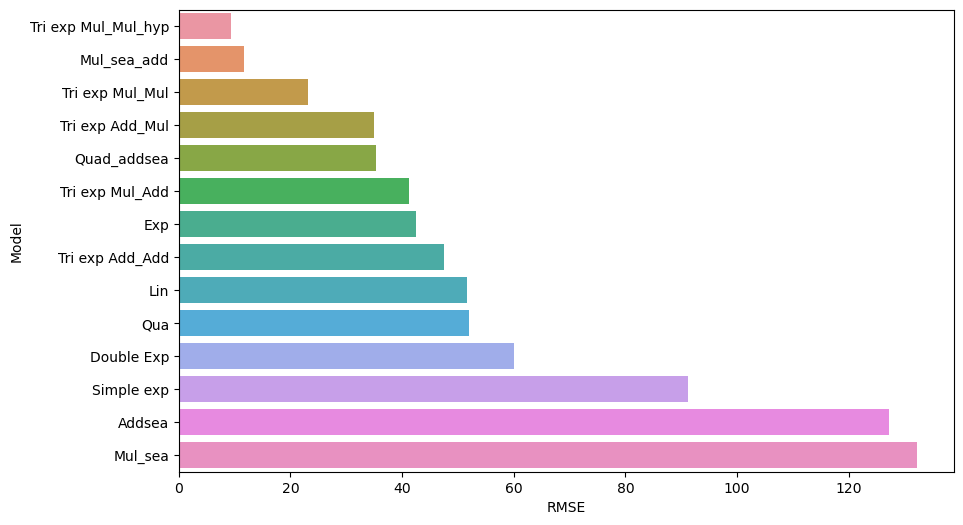

In [221]:
sns.barplot(data = rmse_models,x = 'RMSE',y = 'Model');

# The Holt winter method with multiplicative seasonality and trend, smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.4 is giving the best result and RMSE of the model is also very less when compared to other models

# Now we will fit the model on the entire data set

In [222]:
model_final = ExponentialSmoothing(df['Passengers'],seasonal='mul',trend = 'mul',
                                seasonal_periods=12).fit(smoothing_level = 0.2,smoothing_trend = 0.2,smoothing_seasonal = 0.4)

In [223]:
hw_forecast =model_final.forecast(12)

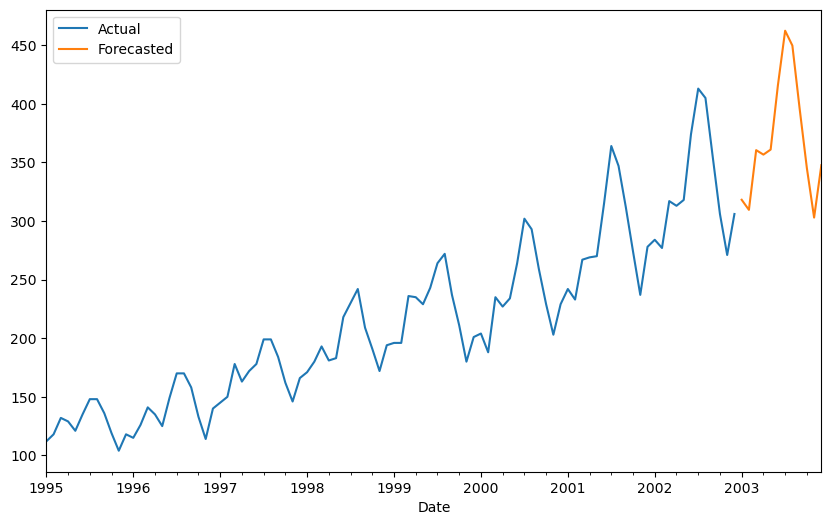

In [224]:
df['Passengers'].plot(legend = True,label = 'Actual')
hw_forecast.plot(legend = True,label = 'Forecasted');

# From the above line plot we can say that the model performance is in line with the actual data and we can use this model for final predictions